In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import simps
from ed import *
from dos import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_G0_semicirc(omFs, mu, t):
    from dos import semicircle
    from scipy.integrate import simps
    ws = np.linspace(-2*t,2*t,1000)
    sc_dos = semicircle(ws,t)
    G0 = np.zeros(len(omFs),dtype=complex)
    for iomF, omF in enumerate(omFs):
        y = sc_dos/(1j*omF+mu-ws)
        G0[iomF] = simps(y, ws)
    return G0

In [3]:
def get_G0_aim(omFs, V, eb, ed, mu):
    G0_aim = np.zeros(len(omFs),dtype=complex)
    for iomF, omF in enumerate(omFs):
        Delta = 0.0
        for ib in range(eb.shape[0]):
            Delta += (V[ib]*np.conj(V[ib])).real/(1j*omF-eb[ib])
        G0_aim[iomF] = 1./(1j*omF - ed + mu - Delta)
    return G0_aim

def get_G0w_aim(ws, eta, V, eb, ed, mu):
    G0_aim = np.zeros((len(ws)),dtype=complex)
    for iw, w in enumerate(ws):
        Delta = 0.0
        for ib in range(eb.shape[0]):
            Delta += (V[ib]*np.conj(V[ib])).real/(w + 1j*eta - eb[ib])
        G0_aim[iw] = (1./(w + 1j*eta - ed + mu - Delta))[0]
    return G0_aim

In [4]:
def cost_func(x, *args):
    omFs, ed, mu, G0, Nb, Nmax = args
    V = x[:Nb] + 1j*x[Nb:2*Nb]
    eb = x[2*Nb:3*Nb]
    G0_aim = get_G0_aim(omFs, V, eb, ed ,mu)
    cost = 0.0
    for iomF in range(Nmax):
        diff = 1./G0_aim[iomF] - 1./G0[iomF]
        cost += (np.conj(diff)*diff).real/omFs[iomF]**1
    return cost 

In [5]:
np.random.seed(1234)
np.set_printoptions(suppress=True, precision=8)

# initial density of state
T = 0.005
t = 0.5
mu = 0.0
Nb = 3#12
Nmax = 100#
NomF = Nmax
omFs = (2*np.arange(NomF)+1)*np.pi*T
G0 = get_G0_semicirc(omFs, mu, t)

no = 2*(1+Nb)
print('no=',no)
FH_list = build_fermion_op(no)
print(len(FH_list))
FH_list_dense = [np.array(FH.todense(),dtype=complex) for FH in FH_list]

ebs = np.random.uniform(-1,1,Nb)
Vrs = np.random.uniform(-0.5,0.5,Nb)
Vis = np.zeros((Nb))
x0 = np.hstack((Vrs,Vis,ebs))
mix = 0.5
maxit = 500

Us = np.arange(0.0,4.1,0.1)
  
doccs = []
for U in Us:
    it = 0
    diff = 1e20
    while diff > 5e-5 and it<maxit:
        print("-------------------------------------- it=%d U=%.2f --------------------------------------"%(it, U))

        # fit V eb
        args = omFs, 0.0, mu, G0, Nb, Nmax
        result = minimize(cost_func,x0,args=args, method='L-BFGS-B', options={'gtol': 1e-2, 'eps': 1e-12})
        print("GA root convergence message---------------------------------")
        print("sucess=",result.success)
        print(result.message)
        V = result.x[:Nb] + 1j*result.x[Nb:2*Nb]
        eb = result.x[2*Nb:3*Nb]
        x0 = result.x
        print('V=',V)
        print('eb=', eb)
    
        # ED part
        h1 = np.array([[-U/2+mu, 0.0],
                        [ 0.0,-U/2+mu]])
        eb = np.kron(eb,np.ones((2)))
        V = np.kron(V,np.eye(2)).T
        #
        V2E = np.zeros((2,2,2,2))
        V2E[1,1,0,0] = U
        V2E[0,0,1,1] = U
        print('V(ED)=',V)
        print('eb(ED)=', eb)

        dm, evals, evecs, docc = solve_Hemb_thermal(T, h1, V, eb, V2E, FH_list, verbose=0)
        
        print('dm=')
        print(dm.real)
        print('trace(dm)=',np.trace(dm).real)
        print('docc=', docc.real)
    
        GomF = compute_GomF_thermal(T, omFs, evals, evecs, FH_list_dense)
      
        # update G0
        G0_new = 1./(1j*omFs + mu - t**2*GomF)
    
        diff = np.sum(np.abs(G0_new  -G0))
        print('diff=', diff)
        it += 1
        G0 = (1-mix)*G0 + mix*G0_new

    # real frequency quantities
    ws = np.linspace(-5,5,200) # frequency mesh
    eta = 0.1 #broadening factor
    Gw = compute_Gw_thermal(T, ws, eta, evals, evecs, FH_list_dense) # real frequency impurity Green's function
    G0w = get_G0w_aim(ws, eta, V[::2,::2], eb[::2], 0.0, mu) # real frequency non-interacting impurity Green's function
    Sigw = 1./G0w - 1./Gw # real frequency self-energy
    Glattw = compute_Glattw_semcircle(ws,eta,Sigw,mu) # real frequency lattice Green's function
    # Matsubara self-energy
    G0 = get_G0_aim(omFs, V[::2,::2], eb[::2], 0.0, mu) # matsubara frequency impurity Green's function
    Sig = 1./G0 - 1./GomF # Matsubara frequency self-energy
    Z = 1./(1-(Sig[0].imag)/(omFs[0])) # quasiparticle weight estimate from Matsubara self-energy
    Glatt = compute_GlattomF_semcircle(omFs,Sig,mu) # real frequency lattice Green's function

    
    np.savetxt('Gimpw_U%.2f.dat'%(U),np.vstack((ws,Gw.real,Gw.imag)).T)
    np.savetxt('Glattw_U%.2f.dat'%(U),np.vstack((ws,Glattw.real,Glattw.imag)).T)
    np.savetxt('Gimp_U%.2f.dat'%(U), np.vstack((omFs,GomF.real,GomF.imag)).T)
    np.savetxt('Glatt_U%.2f.dat'%(U), np.vstack((omFs,Glatt.real,Glatt.imag)).T)
    np.savetxt('G0_U%.2f.dat'%(U), np.vstack((omFs,G0.real,G0.imag)).T)
    np.savetxt('Sig_U%.2f.dat'%(U), np.vstack((omFs,Sig.real,Sig.imag)).T)
    np.savetxt('Sigw_U%.2f.dat'%(U), np.vstack((ws,Sigw.real,Sigw.imag)).T)
    np.savetxt('x0_U%.2f.dat'%(U), x0)
    doccs.append(docc.real)
    print(U, dm[0,0].real, dm[1,1].real, docc.real, Z, diff)
    f = open('U_occ_docc_Z_diff_metal2mott.dat','a')
    print(U, dm[0,0].real, dm[1,1].real, docc.real, Z, diff, file=f)
    f.close()

no= 8
8
-------------------------------------- it=0 U=0.00 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
V= [ 0.26451211+0.j  0.26451413+0.j -0.07980677+0.j]
eb= [-0.15225325  0.15225749  0.00000006]
V(ED)= [[ 0.26451211+0.j  0.        +0.j]
 [ 0.        +0.j  0.26451211+0.j]
 [ 0.26451413+0.j  0.        +0.j]
 [ 0.        +0.j  0.26451413+0.j]
 [-0.07980677+0.j -0.        +0.j]
 [-0.        +0.j -0.07980677+0.j]]
eb(ED)= [-0.15225325 -0.15225325  0.15225749  0.15225749  0.00000006  0.00000006]
Egs= -0.8804210979834246
evals= [0.         0.0295913  0.0295913  0.02959229 0.02959229 0.0591826
 0.05918359 0.05918359 0.05918359 0.05918359]
dm=
[[ 0.50000064 -0.         -0.30056388 -0.         -0.30056219  0.
   0.26261753 -0.        ]
 [-0.          0.50000064 -0.         -0.30056388  0.         -0.30056219
  -0.          0.26261753]
 [-0.30056388 -0.          0.76312438 -0.  

dm=
[[ 0.49999916  0.         -0.30193907  0.         -0.30193606 -0.
   0.25930227 -0.        ]
 [ 0.          0.49999916  0.         -0.30193907 -0.         -0.30193606
   0.          0.25930227]
 [-0.30193907  0.          0.75989382  0.          0.0000013  -0.
   0.29951154 -0.        ]
 [ 0.         -0.30193907  0.          0.75989382 -0.          0.0000013
   0.          0.29951154]
 [-0.30193606 -0.          0.0000013  -0.          0.24010266  0.
  -0.29951159  0.        ]
 [-0.         -0.30193606 -0.          0.0000013   0.          0.24010266
  -0.         -0.29951159]
 [ 0.25930227  0.          0.29951154  0.         -0.29951159 -0.
   0.50000406 -0.        ]
 [-0.          0.25930227 -0.          0.29951154  0.         -0.29951159
  -0.          0.50000406]]
trace(dm)= 3.999999403415436
docc= 0.24999915883894447
diff= 0.049911305578136486
-------------------------------------- it=6 U=0.00 --------------------------------------
GA root convergence message---------------------

diff= 0.001565224973322403
-------------------------------------- it=11 U=0.00 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.25520119+0.j  0.25520006+0.j -0.0789443 +0.j]
eb= [-0.14135716  0.14135674  0.00000007]
V(ED)= [[ 0.25520119+0.j  0.        +0.j]
 [ 0.        +0.j  0.25520119+0.j]
 [ 0.25520006+0.j  0.        +0.j]
 [ 0.        +0.j  0.25520006+0.j]
 [-0.0789443 +0.j -0.        +0.j]
 [-0.        +0.j -0.0789443 +0.j]]
eb(ED)= [-0.14135716 -0.14135716  0.14135674  0.14135674  0.00000007  0.00000007]
Egs= -0.8456654195368055
evals= [0.         0.02828356 0.02828356 0.02828397 0.02828397 0.05656712
 0.05656753 0.05656753 0.05656753 0.05656753]
dm=
[[ 0.49999939 -0.         -0.30193837  0.         -0.30193628 -0.
   0.25930285 -0.        ]
 [-0.          0.49999939 -0.         -0.30193837  0.         -0.30193628
  -0.          0.25930285]
 [-0.30193837 -0.    

dm=
[[ 0.49999944  0.         -0.30168534 -0.         -0.30168329  0.
   0.25918038 -0.        ]
 [ 0.          0.49999944  0.         -0.30168534 -0.         -0.30168329
   0.          0.25918038]
 [-0.30168534  0.          0.76005012  0.          0.00000065 -0.
   0.29943147 -0.        ]
 [-0.         -0.30168534  0.          0.76005012  0.          0.00000065
  -0.          0.29943147]
 [-0.30168329 -0.          0.00000065  0.          0.23994773  0.
  -0.29943173  0.        ]
 [ 0.         -0.30168329 -0.          0.00000065  0.          0.23994773
  -0.         -0.29943173]
 [ 0.25918038  0.          0.29943147 -0.         -0.29943173 -0.
   0.50000243 -0.        ]
 [-0.          0.25918038 -0.          0.29943147  0.         -0.29943173
  -0.          0.50000243]]
trace(dm)= 3.9999994432427806
docc= 0.24065552304260476
diff= 5.262119831425475
-------------------------------------- it=1 U=0.10 --------------------------------------
GA root convergence message----------------------

diff= 0.17013356804261928
-------------------------------------- it=6 U=0.10 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.25510898+0.j  0.25510822+0.j -0.07894749+0.j]
eb= [-0.14134702  0.14133234 -0.00000195]
V(ED)= [[ 0.25510898+0.j  0.        +0.j]
 [ 0.        +0.j  0.25510898+0.j]
 [ 0.25510822+0.j  0.        +0.j]
 [ 0.        +0.j  0.25510822+0.j]
 [-0.07894749+0.j -0.        +0.j]
 [-0.        +0.j -0.07894749+0.j]]
eb(ED)= [-0.14134702 -0.14134702  0.14133234  0.14133234 -0.00000195 -0.00000195]
Egs= -0.8709123152690019
evals= [0.         0.02828015 0.02828015 0.02828837 0.02828837 0.05618792
 0.05618792 0.05618792 0.05694812 0.05695641]
dm=
[[ 0.49999993  0.         -0.30165128  0.         -0.3016681  -0.
   0.25923795  0.        ]
 [ 0.          0.49999993  0.         -0.30165128 -0.         -0.3016681
   0.          0.25923795]
 [-0.30165128  0.       

dm=
[[ 0.50000423 -0.         -0.30166447 -0.         -0.30167807  0.
   0.25921009  0.        ]
 [-0.          0.50000423 -0.         -0.30166447  0.         -0.30167807
  -0.          0.25921009]
 [-0.30166447 -0.          0.76008644 -0.         -0.000002    0.
   0.29942063  0.        ]
 [-0.         -0.30166447 -0.          0.76008644  0.         -0.000002
  -0.          0.29942063]
 [-0.30167807  0.         -0.000002    0.          0.23992455 -0.
  -0.29941603 -0.        ]
 [ 0.         -0.30167807  0.         -0.000002   -0.          0.23992455
   0.         -0.29941603]
 [ 0.25921009 -0.          0.29942063 -0.         -0.29941603  0.
   0.49998676  0.        ]
 [ 0.          0.25921009  0.          0.29942063 -0.         -0.29941603
   0.          0.49998676]]
trace(dm)= 4.0000039612576135
docc= 0.2406565515432047
diff= 0.003190576646861752
-------------------------------------- it=12 U=0.10 --------------------------------------
GA root convergence message---------------------

diff= 0.0005257656436481405
-------------------------------------- it=17 U=0.10 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.25508067+0.j  0.25507881+0.j -0.07894217+0.j]
eb= [-0.14129516  0.14129737  0.00000062]
V(ED)= [[ 0.25508067+0.j  0.        +0.j]
 [ 0.        +0.j  0.25508067+0.j]
 [ 0.25507881+0.j  0.        +0.j]
 [ 0.        +0.j  0.25507881+0.j]
 [-0.07894217+0.j -0.        +0.j]
 [-0.        +0.j -0.07894217+0.j]]
eb(ED)= [-0.14129516 -0.14129516  0.14129737  0.14129737  0.00000062  0.00000062]
Egs= -0.8707724081221779
evals= [0.         0.02827628 0.02827628 0.02827874 0.02827874 0.05617467
 0.05617467 0.05617467 0.05694014 0.05694262]
dm=
[[ 0.49999912 -0.         -0.30167206  0.         -0.30166538 -0.
   0.25921602  0.        ]
 [-0.          0.49999912 -0.         -0.30167206  0.         -0.30166538
  -0.          0.25921602]
 [-0.30167206 -0.   

dm=
[[ 0.49999909 -0.         -0.30167272 -0.         -0.30166854 -0.
   0.2592114  -0.        ]
 [-0.          0.49999909  0.         -0.30167272 -0.         -0.30166854
   0.          0.2592114 ]
 [-0.30167272  0.          0.76007986  0.          0.00000152 -0.
   0.2994172  -0.        ]
 [-0.         -0.30167272  0.          0.76007986 -0.          0.00000152
   0.          0.2994172 ]
 [-0.30166854 -0.          0.00000152 -0.          0.23991525  0.
  -0.2994174   0.        ]
 [-0.         -0.30166854 -0.          0.00000152  0.          0.23991525
  -0.         -0.2994174 ]
 [ 0.2592114   0.          0.2994172   0.         -0.2994174  -0.
   0.50000489 -0.        ]
 [-0.          0.2592114  -0.          0.2994172   0.         -0.2994174
  -0.          0.50000489]]
trace(dm)= 3.999998200924145
docc= 0.24065083737099172
diff= 6.52356282950974e-05
-------------------------------------- it=23 U=0.10 --------------------------------------
GA root convergence message--------------------

diff= 0.6701179115712385
-------------------------------------- it=4 U=0.20 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.254499  +0.j  0.25447903+0.j -0.07891801+0.j]
eb= [-0.1409049   0.14086613 -0.00000207]
V(ED)= [[ 0.254499  +0.j  0.        +0.j]
 [ 0.        +0.j  0.254499  +0.j]
 [ 0.25447903+0.j  0.        +0.j]
 [ 0.        +0.j  0.25447903+0.j]
 [-0.07891801+0.j -0.        +0.j]
 [-0.        +0.j -0.07891801+0.j]]
eb(ED)= [-0.1409049  -0.1409049   0.14086613  0.14086613 -0.00000207 -0.00000207]
Egs= -0.8953412993891056
evals= [0.         0.02822837 0.02822837 0.02823894 0.02823894 0.05571333
 0.05571333 0.05571333 0.05723963 0.05725044]
dm=
[[ 0.49999261  0.         -0.30087684  0.         -0.30088477 -0.
   0.25890642  0.        ]
 [ 0.          0.49999261  0.         -0.30087684 -0.         -0.30088477
   0.          0.25890642]
 [-0.30087684  0.       

dm=
[[ 0.50000397  0.         -0.30089382  0.         -0.30087709 -0.
   0.25889865 -0.        ]
 [ 0.          0.50000397  0.         -0.30089382 -0.         -0.30087709
   0.          0.25889865]
 [-0.30089382  0.          0.76057829  0.          0.00002759 -0.
   0.29915644 -0.        ]
 [ 0.         -0.30089382  0.          0.76057829 -0.          0.00002759
   0.          0.29915644]
 [-0.30087709 -0.          0.00002759 -0.          0.23936848  0.
  -0.29912965  0.        ]
 [-0.         -0.30087709 -0.          0.00002759  0.          0.23936848
  -0.         -0.29912965]
 [ 0.25889865  0.          0.29915644  0.         -0.29912965 -0.
   0.50004136 -0.        ]
 [-0.          0.25889865 -0.          0.29915644  0.         -0.29912965
  -0.          0.50004136]]
trace(dm)= 3.9999842040118687
docc= 0.23131130730986285
diff= 0.010669181878080476
-------------------------------------- it=10 U=0.20 --------------------------------------
GA root convergence message------------------

diff= 0.00034065472024125907
-------------------------------------- it=15 U=0.20 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.25460581+0.j  0.25461933+0.j -0.07892261+0.j]
eb= [-0.14095942  0.14098919  0.000002  ]
V(ED)= [[ 0.25460581+0.j  0.        +0.j]
 [ 0.        +0.j  0.25460581+0.j]
 [ 0.25461933+0.j  0.        +0.j]
 [ 0.        +0.j  0.25461933+0.j]
 [-0.07892261+0.j -0.        +0.j]
 [-0.        +0.j -0.07892261+0.j]]
eb(ED)= [-0.14095942 -0.14095942  0.14098919  0.14098919  0.000002    0.000002  ]
Egs= -0.8956634907772515
evals= [0.         0.02823464 0.02823464 0.02824398 0.02824398 0.05572417
 0.05572417 0.05572417 0.05725272 0.05726225]
dm=
[[ 0.50000504  0.         -0.30089104  0.         -0.30088165 -0.
   0.25889651 -0.        ]
 [ 0.          0.50000504  0.         -0.30089104 -0.         -0.30088165
   0.          0.25889651]
 [-0.30089104  0.  

diff= 5.23183132237496
-------------------------------------- it=1 U=0.30 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.25427727+0.j  0.25428222+0.j -0.07910831+0.j]
eb= [-0.14243023  0.14243903  0.00000041]
V(ED)= [[ 0.25427727+0.j  0.        +0.j]
 [ 0.        +0.j  0.25427727+0.j]
 [ 0.25428222+0.j  0.        +0.j]
 [ 0.        +0.j  0.25428222+0.j]
 [-0.07910831+0.j -0.        +0.j]
 [-0.        +0.j -0.07910831+0.j]]
eb(ED)= [-0.14243023 -0.14243023  0.14243903  0.14243903  0.00000041  0.00000041]
Egs= -0.92395098137455
evals= [0.         0.02855685 0.02855685 0.02855899 0.02855899 0.05594393
 0.05594393 0.05594393 0.05835659 0.05835881]
dm=
[[ 0.50000171  0.         -0.29888343  0.         -0.29888251  0.
   0.25999989  0.        ]
 [ 0.          0.50000171 -0.         -0.29888343 -0.         -0.29888251
  -0.          0.25999989]
 [-0.29888343 -0.          0

dm=
[[ 0.49999122  0.         -0.29956977  0.         -0.29957703 -0.
   0.25837867 -0.        ]
 [ 0.          0.49999122  0.         -0.29956977 -0.         -0.29957703
   0.          0.25837867]
 [-0.29956977  0.          0.76151088  0.         -0.00003425 -0.
   0.29866208 -0.        ]
 [ 0.         -0.29956977  0.          0.76151088 -0.         -0.00003425
   0.          0.29866208]
 [-0.29957703 -0.         -0.00003425 -0.          0.23854614  0.
  -0.29870136  0.        ]
 [-0.         -0.29957703 -0.         -0.00003425  0.          0.23854614
  -0.         -0.29870136]
 [ 0.25837867  0.          0.29866208  0.         -0.29870136 -0.
   0.49996029 -0.        ]
 [-0.          0.25837867 -0.          0.29866208  0.         -0.29870136
  -0.          0.49996029]]
trace(dm)= 4.000017038398361
docc= 0.22196238800082554
diff= 0.08442454316036271
-------------------------------------- it=7 U=0.30 --------------------------------------
GA root convergence message---------------------

diff= 0.00264990532586718
-------------------------------------- it=12 U=0.30 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.25386513+0.j  0.25384004+0.j -0.07889298+0.j]
eb= [-0.14049343  0.14044653 -0.00000246]
V(ED)= [[ 0.25386513+0.j  0.        +0.j]
 [ 0.        +0.j  0.25386513+0.j]
 [ 0.25384004+0.j  0.        +0.j]
 [ 0.        +0.j  0.25384004+0.j]
 [-0.07889298+0.j -0.        +0.j]
 [-0.        +0.j -0.07889298+0.j]]
eb(ED)= [-0.14049343 -0.14049343  0.14044653  0.14044653 -0.00000246 -0.00000246]
Egs= -0.9206973264736853
evals= [0.         0.02817412 0.02817412 0.02818655 0.02818655 0.05523681
 0.05523681 0.05523681 0.05753777 0.05755064]
dm=
[[ 0.49999142 -0.         -0.29956948 -0.         -0.29957744  0.
   0.2583786   0.        ]
 [-0.          0.49999142 -0.         -0.29956948  0.         -0.29957744
  -0.          0.2583786 ]
 [-0.29956948 -0.     

dm=
[[ 0.49999244 -0.         -0.29956867 -0.         -0.29958032  0.
   0.25837618 -0.        ]
 [-0.          0.49999244 -0.         -0.29956867  0.         -0.29958032
  -0.          0.25837618]
 [-0.29956867 -0.          0.76151009 -0.         -0.00003468  0.
   0.29866371 -0.        ]
 [-0.         -0.29956867 -0.          0.76151009  0.         -0.00003468
  -0.          0.29866371]
 [-0.29958032  0.         -0.00003468  0.          0.23855041 -0.
  -0.29870147  0.        ]
 [ 0.         -0.29958032  0.         -0.00003468 -0.          0.23855041
   0.         -0.29870147]
 [ 0.25837618 -0.          0.29866371 -0.         -0.29870147  0.
   0.49995618 -0.        ]
 [-0.          0.25837618 -0.          0.29866371  0.         -0.29870147
  -0.          0.49995618]]
trace(dm)= 4.000018241104023
docc= 0.22196378686391421
diff= 8.337604937291999e-05
-------------------------------------- it=18 U=0.30 --------------------------------------
GA root convergence message------------------

diff= 0.6641134046339953
-------------------------------------- it=4 U=0.40 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.25268197+0.j  0.25267673+0.j -0.07884562+0.j]
eb= [-0.13969204  0.13968062 -0.00000072]
V(ED)= [[ 0.25268197+0.j  0.        +0.j]
 [ 0.        +0.j  0.25268197+0.j]
 [ 0.25267673+0.j  0.        +0.j]
 [ 0.        +0.j  0.25267673+0.j]
 [-0.07884562+0.j -0.        +0.j]
 [-0.        +0.j -0.07884562+0.j]]
eb(ED)= [-0.13969204 -0.13969204  0.13968062  0.13968062 -0.00000072 -0.00000072]
Egs= -0.9452550304391593
evals= [0.         0.02808992 0.02808992 0.02809347 0.02809347 0.05469469
 0.05469469 0.05469469 0.05778695 0.05779065]
dm=
[[ 0.49999842  0.         -0.29772328  0.         -0.29772722 -0.
   0.25765414 -0.        ]
 [ 0.          0.49999842  0.         -0.29772328 -0.         -0.29772722
   0.          0.25765414]
 [-0.29772328  0.       

dm=
[[ 0.50000113  0.         -0.29773573  0.         -0.29773471 -0.
   0.25764144 -0.        ]
 [ 0.          0.50000113  0.         -0.29773573 -0.         -0.29773471
   0.          0.25764144]
 [-0.29773573  0.          0.762708    0.          0.00000459 -0.
   0.29803417 -0.        ]
 [ 0.         -0.29773573  0.          0.762708   -0.          0.00000459
   0.          0.29803417]
 [-0.29773471 -0.          0.00000459 -0.          0.23728436  0.
  -0.298029    0.        ]
 [-0.         -0.29773471 -0.          0.00000459  0.          0.23728436
  -0.         -0.298029  ]
 [ 0.25764144  0.          0.29803417  0.         -0.298029   -0.
   0.50000519 -0.        ]
 [-0.          0.25764144 -0.          0.29803417  0.         -0.298029
  -0.          0.50000519]]
trace(dm)= 3.999997340094965
docc= 0.21265170577011522
diff= 0.010597922217148463
-------------------------------------- it=10 U=0.40 --------------------------------------
GA root convergence message---------------------

diff= 0.00033709174737042
-------------------------------------- it=15 U=0.40 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.25279885+0.j  0.25280076+0.j -0.07885165+0.j]
eb= [-0.13977662  0.13977964 -0.00000003]
V(ED)= [[ 0.25279885+0.j  0.        +0.j]
 [ 0.        +0.j  0.25279885+0.j]
 [ 0.25280076+0.j  0.        +0.j]
 [ 0.        +0.j  0.25280076+0.j]
 [-0.07885165+0.j -0.        +0.j]
 [-0.        +0.j -0.07885165+0.j]]
eb(ED)= [-0.13977662 -0.13977662  0.13977964  0.13977964 -0.00000003 -0.00000003]
Egs= -0.9456296011716306
evals= [0.         0.02809845 0.02809845 0.02809894 0.02809894 0.05470764
 0.05470764 0.05470764 0.05780535 0.05780588]
dm=
[[ 0.50000049  0.         -0.29773068  0.         -0.29773019 -0.
   0.25765175 -0.        ]
 [ 0.          0.50000049  0.         -0.29773068 -0.         -0.29773019
  -0.          0.25765175]
 [-0.29773068  0.     

dm=
[[ 0.49999989 -0.         -0.29467362 -0.         -0.29468451  0.
   0.2582765   0.        ]
 [-0.          0.49999989 -0.         -0.29467362  0.         -0.29468451
  -0.          0.2582765 ]
 [-0.29467362 -0.          0.76594261 -0.         -0.00001081  0.
   0.29664796  0.        ]
 [-0.         -0.29467362 -0.          0.76594261  0.         -0.00001081
  -0.          0.29664796]
 [-0.29468451  0.         -0.00001081  0.          0.23408094 -0.
  -0.29665664 -0.        ]
 [ 0.         -0.29468451  0.         -0.00001081 -0.          0.23408094
   0.         -0.29665664]
 [ 0.2582765  -0.          0.29664796 -0.         -0.29665664  0.
   0.49998018  0.        ]
 [ 0.          0.2582765   0.          0.29664796 -0.         -0.29665664
   0.          0.49998018]]
trace(dm)= 4.000007239831314
docc= 0.20334899638464907
diff= 2.5444170859488553
-------------------------------------- it=2 U=0.50 --------------------------------------
GA root convergence message----------------------

diff= 0.08349872081701425
-------------------------------------- it=7 U=0.50 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.25146238+0.j  0.25146439+0.j -0.07880039+0.j]
eb= [-0.13891828  0.13891519 -0.00000078]
V(ED)= [[ 0.25146238+0.j  0.        +0.j]
 [ 0.        +0.j  0.25146238+0.j]
 [ 0.25146439+0.j  0.        +0.j]
 [ 0.        +0.j  0.25146439+0.j]
 [-0.07880039+0.j -0.        +0.j]
 [-0.        +0.j -0.07880039+0.j]]
eb(ED)= [-0.13891828 -0.13891828  0.13891519  0.13891519 -0.00000078 -0.00000078]
Egs= -0.9707041591178899
evals= [0.         0.02799521 0.02799521 0.02799823 0.02799823 0.05413964
 0.05413964 0.05413964 0.05803223 0.05803536]
dm=
[[ 0.50000064 -0.         -0.29534623 -0.         -0.29535389  0.
   0.25672074  0.        ]
 [-0.          0.50000064 -0.         -0.29534623  0.         -0.29535389
  -0.          0.25672074]
 [-0.29534623 -0.      

dm=
[[ 0.49999954  0.         -0.29535557  0.         -0.29535487 -0.
   0.25670933  0.        ]
 [ 0.          0.49999954  0.         -0.29535557 -0.         -0.29535487
  -0.          0.25670933]
 [-0.29535557  0.          0.76432777  0.         -0.00000133 -0.
   0.29717507  0.        ]
 [ 0.         -0.29535557  0.          0.76432777 -0.         -0.00000133
  -0.          0.29717507]
 [-0.29535487 -0.         -0.00000133 -0.          0.23567356  0.
  -0.29717692 -0.        ]
 [-0.         -0.29535487 -0.         -0.00000133  0.          0.23567356
   0.         -0.29717692]
 [ 0.25670933 -0.          0.29717507 -0.         -0.29717692  0.
   0.4999991  -0.        ]
 [ 0.          0.25670933  0.          0.29717507 -0.         -0.29717692
  -0.          0.4999991 ]]
trace(dm)= 3.99999995414305
docc= 0.20334789256400565
diff= 0.0013158723879964278
-------------------------------------- it=13 U=0.50 --------------------------------------
GA root convergence message-------------------

diff= 5.843889183761572e-05
-------------------------------------- it=18 U=0.50 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.25146463+0.j  0.25146299+0.j -0.07879902+0.j]
eb= [-0.1389068   0.13890466  0.00000008]
V(ED)= [[ 0.25146463+0.j  0.        +0.j]
 [ 0.        +0.j  0.25146463+0.j]
 [ 0.25146299+0.j  0.        +0.j]
 [ 0.        +0.j  0.25146299+0.j]
 [-0.07879902+0.j -0.        +0.j]
 [-0.        +0.j -0.07879902+0.j]]
eb(ED)= [-0.1389068  -0.1389068   0.13890466  0.13890466  0.00000008  0.00000008]
Egs= -0.9706902714315884
evals= [0.         0.02799421 0.02799421 0.02799439 0.02799439 0.0541353
 0.0541353  0.0541353  0.05802972 0.05802993]
dm=
[[ 0.49999961 -0.         -0.2953552  -0.         -0.29535509  0.
   0.25670945  0.        ]
 [-0.          0.49999961 -0.         -0.2953552   0.         -0.29535509
  -0.          0.25670945]
 [-0.2953552  -0.    

dm=
[[ 0.49999655  0.         -0.29242471  0.         -0.29243151 -0.
   0.25555338  0.        ]
 [ 0.          0.49999655  0.         -0.29242471 -0.         -0.29243151
  -0.          0.25555338]
 [-0.29242471  0.          0.76633895  0.         -0.00002053 -0.
   0.29609389  0.        ]
 [ 0.         -0.29242471  0.          0.76633895 -0.         -0.00002053
  -0.          0.29609389]
 [-0.29243151 -0.         -0.00002053 -0.          0.23369553  0.
  -0.29611541 -0.        ]
 [-0.         -0.29243151 -0.         -0.00002053  0.          0.23369553
   0.         -0.29611541]
 [ 0.25555338 -0.          0.29609389 -0.         -0.29611541  0.
   0.49997472 -0.        ]
 [ 0.          0.25555338  0.          0.29609389 -0.         -0.29611541
  -0.          0.49997472]]
trace(dm)= 4.00001148179646
docc= 0.19404148990602366
diff= 0.32962381832272636
-------------------------------------- it=5 U=0.60 --------------------------------------
GA root convergence message----------------------

diff= 0.010469993465609938
-------------------------------------- it=10 U=0.60 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.24976704+0.j  0.2497805 +0.j -0.07873116+0.j]
eb= [-0.13777763  0.13781215  0.00000258]
V(ED)= [[ 0.24976704+0.j  0.        +0.j]
 [ 0.        +0.j  0.24976704+0.j]
 [ 0.2497805 +0.j  0.        +0.j]
 [ 0.        +0.j  0.2497805 +0.j]
 [-0.07873116+0.j -0.        +0.j]
 [-0.        +0.j -0.07873116+0.j]]
eb(ED)= [-0.13777763 -0.13777763  0.13781215  0.13781215  0.00000258  0.00000258]
Egs= -0.9955566902383187
evals= [0.         0.02785533 0.02785533 0.02786756 0.02786756 0.05350857
 0.05350857 0.05350857 0.05819923 0.05821226]
dm=
[[ 0.50000328 -0.         -0.29244971 -0.         -0.29243271  0.
   0.25554069  0.        ]
 [-0.          0.50000328 -0.         -0.29244971  0.         -0.29243271
  -0.          0.25554069]
 [-0.29244971 -0.    

dm=
[[ 0.50000328 -0.         -0.29244971 -0.         -0.29243271  0.
   0.25554069  0.        ]
 [-0.          0.50000328 -0.         -0.29244971  0.         -0.29243271
  -0.          0.25554069]
 [-0.29244971 -0.          0.76627494 -0.          0.00002968  0.
   0.29612915  0.        ]
 [-0.         -0.29244971 -0.          0.76627494  0.          0.00002968
  -0.          0.29612915]
 [-0.29243271  0.          0.00002968  0.          0.23366983 -0.
  -0.29610074 -0.        ]
 [ 0.         -0.29243271  0.          0.00002968 -0.          0.23366983
   0.         -0.29610074]
 [ 0.25554069 -0.          0.29612915 -0.         -0.29610074  0.
   0.50004276  0.        ]
 [ 0.          0.25554069  0.          0.29612915 -0.         -0.29610074
   0.          0.50004276]]
trace(dm)= 3.9999815964707803
docc= 0.1940671458871114
diff= 0.00016359364790008546
-------------------------------------- it=16 U=0.60 --------------------------------------
GA root convergence message-----------------

dm=
[[ 0.49999834 -0.         -0.28876745 -0.         -0.2887931   0.
   0.25455653  0.        ]
 [-0.          0.49999834 -0.         -0.28876745  0.         -0.2887931
  -0.          0.25455653]
 [-0.28876745 -0.          0.769151   -0.         -0.00003249  0.
   0.29465842  0.        ]
 [-0.         -0.28876745 -0.          0.769151    0.         -0.00003249
  -0.          0.29465842]
 [-0.2887931   0.         -0.00003249  0.          0.23091451 -0.
  -0.29468706 -0.        ]
 [ 0.         -0.2887931   0.         -0.00003249 -0.          0.23091451
   0.         -0.29468706]
 [ 0.25455653 -0.          0.29465842 -0.         -0.29468706  0.
   0.49994703  0.        ]
 [ 0.          0.25455653  0.          0.29465842 -0.         -0.29468706
   0.          0.49994703]]
trace(dm)= 4.000021752243807
docc= 0.18476590257370604
diff= 1.2819324207490999
-------------------------------------- it=3 U=0.70 --------------------------------------
GA root convergence message-----------------------

diff= 0.04102842873291168
-------------------------------------- it=8 U=0.70 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.2477218 +0.j  0.24772213+0.j -0.0786441 +0.j]
eb= [-0.1364284   0.13643125  0.00000037]
V(ED)= [[ 0.2477218 +0.j  0.        +0.j]
 [ 0.        +0.j  0.2477218 +0.j]
 [ 0.24772213+0.j  0.        +0.j]
 [ 0.        +0.j  0.24772213+0.j]
 [-0.0786441 +0.j -0.        +0.j]
 [-0.        +0.j -0.0786441 +0.j]]
eb(ED)= [-0.1364284  -0.1364284   0.13643125  0.13643125  0.00000037  0.00000037]
Egs= -1.020324035640982
evals= [0.         0.02769504 0.02769504 0.02769652 0.02769652 0.05281919
 0.05281919 0.05281919 0.05834327 0.05834485]
dm=
[[ 0.50000006 -0.         -0.28898768 -0.         -0.28898488  0.
   0.25412223  0.        ]
 [-0.          0.50000006 -0.         -0.28898768  0.         -0.28898488
  -0.          0.25412223]
 [-0.28898768 -0.       

dm=
[[ 0.49999979  0.         -0.28898697  0.         -0.2889806  -0.
   0.25413016  0.        ]
 [ 0.          0.49999979  0.         -0.28898697 -0.         -0.2889806
   0.          0.25413016]
 [-0.28898697  0.          0.76864615  0.          0.00000512 -0.
   0.29483703  0.        ]
 [ 0.         -0.28898697  0.          0.76864615 -0.          0.00000512
  -0.          0.29483703]
 [-0.2889806  -0.          0.00000512 -0.          0.23134164  0.
  -0.29483335 -0.        ]
 [-0.         -0.2889806  -0.          0.00000512  0.          0.23134164
   0.         -0.29483335]
 [ 0.25413016  0.          0.29483703 -0.         -0.29483335  0.
   0.50001024 -0.        ]
 [ 0.          0.25413016  0.          0.29483703 -0.         -0.29483335
  -0.          0.50001024]]
trace(dm)= 3.9999956203767972
docc= 0.18479941400010938
diff= 0.000667658169421174
-------------------------------------- it=14 U=0.70 --------------------------------------
GA root convergence message-------------------

dm=
[[ 0.49999981  0.         -0.28537021 -0.         -0.28536393  0.
   0.25229252 -0.        ]
 [ 0.          0.49999981  0.         -0.28537021 -0.         -0.28536393
  -0.          0.25229252]
 [-0.28537021  0.          0.77093546 -0.          0.00000504  0.
   0.29358524 -0.        ]
 [-0.         -0.28537021 -0.          0.77093546  0.          0.00000504
   0.          0.29358524]
 [-0.28536393 -0.          0.00000504  0.          0.22905245 -0.
  -0.29358153  0.        ]
 [ 0.         -0.28536393  0.          0.00000504 -0.          0.22905245
   0.         -0.29358153]
 [ 0.25229252 -0.          0.29358524  0.         -0.29358153  0.
   0.50001007  0.        ]
 [-0.          0.25229252 -0.          0.29358524  0.         -0.29358153
   0.          0.50001007]]
trace(dm)= 3.9999955680872716
docc= 0.17614656372215262
diff= 5.09877307750293
-------------------------------------- it=1 U=0.80 --------------------------------------
GA root convergence message-----------------------

diff= 0.16247896538958032
-------------------------------------- it=6 U=0.80 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.24539445+0.j  0.24539101+0.j -0.07855361+0.j]
eb= [-0.13494263  0.13493619 -0.00000051]
V(ED)= [[ 0.24539445+0.j  0.        +0.j]
 [ 0.        +0.j  0.24539445+0.j]
 [ 0.24539101+0.j  0.        +0.j]
 [ 0.        +0.j  0.24539101+0.j]
 [-0.07855361+0.j -0.        +0.j]
 [-0.        +0.j -0.07855361+0.j]]
eb(ED)= [-0.13494263 -0.13494263  0.13493619  0.13493619 -0.00000051 -0.00000051]
Egs= -1.0452643693040375
evals= [0.         0.02751515 0.02751515 0.0275171  0.0275171  0.05209919
 0.05209919 0.05209919 0.05847208 0.05847419]
dm=
[[ 0.4999992   0.         -0.28495938  0.         -0.28496034 -0.
   0.25250808  0.        ]
 [ 0.          0.4999992  -0.         -0.28495938 -0.         -0.28496034
  -0.          0.25250808]
 [-0.28495938 -0.      

dm=
[[ 0.49999932 -0.         -0.2849604  -0.         -0.28495997  0.
   0.25251506  0.        ]
 [-0.          0.49999932 -0.         -0.2849604   0.         -0.28495997
  -0.          0.25251506]
 [-0.2849604  -0.          0.77143648 -0.         -0.00000318  0.
   0.29330733  0.        ]
 [-0.         -0.2849604  -0.          0.77143648  0.         -0.00000318
  -0.          0.29330733]
 [-0.28495997  0.         -0.00000318  0.          0.22856746 -0.
  -0.29331106 -0.        ]
 [ 0.         -0.28495997  0.         -0.00000318 -0.          0.22856746
   0.         -0.29331106]
 [ 0.25251506 -0.          0.29330733 -0.         -0.29331106  0.
   0.49999729  0.        ]
 [ 0.          0.25251506  0.          0.29330733 -0.         -0.29331106
   0.          0.49999729]]
trace(dm)= 4.000001105721328
docc= 0.17557363758870292
diff= 0.0024446087252043176
-------------------------------------- it=12 U=0.80 --------------------------------------
GA root convergence message------------------

diff= 7.701698492211195e-05
-------------------------------------- it=17 U=0.80 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.24542336+0.j  0.24542   +0.j -0.07855629+0.j]
eb= [-0.13496962  0.13496504 -0.00000012]
V(ED)= [[ 0.24542336+0.j  0.        +0.j]
 [ 0.        +0.j  0.24542336+0.j]
 [ 0.24542   +0.j  0.        +0.j]
 [ 0.        +0.j  0.24542   +0.j]
 [-0.07855629+0.j -0.        +0.j]
 [-0.        +0.j -0.07855629+0.j]]
eb(ED)= [-0.13496962 -0.13496962  0.13496504  0.13496504 -0.00000012 -0.00000012]
Egs= -1.0453611782780818
evals= [0.         0.02751889 0.02751889 0.02751965 0.02751965 0.0521046
 0.0521046  0.0521046  0.05848076 0.05848163]
dm=
[[ 0.49999928  0.         -0.28496066  0.         -0.28496    -0.
   0.25251478  0.        ]
 [ 0.          0.49999928  0.         -0.28496066 -0.         -0.28496
  -0.          0.25251478]
 [-0.28496066  0.       

dm=
[[ 0.49999704 -0.         -0.28035557 -0.         -0.28036463  0.
   0.25065919 -0.        ]
 [-0.          0.49999704 -0.         -0.28035557  0.         -0.28036463
  -0.          0.25065919]
 [-0.28035557 -0.          0.77467095 -0.         -0.00002546  0.
   0.29150545 -0.        ]
 [-0.         -0.28035557 -0.          0.77467095  0.         -0.00002546
  -0.          0.29150545]
 [-0.28036463  0.         -0.00002546  0.          0.22537082 -0.
  -0.29153121  0.        ]
 [ 0.         -0.28036463  0.         -0.00002546 -0.          0.22537082
   0.         -0.29153121]
 [ 0.25065919 -0.          0.29150545 -0.         -0.29153121  0.
   0.49996878 -0.        ]
 [-0.          0.25065919 -0.          0.29150545  0.         -0.29153121
  -0.          0.49996878]]
trace(dm)= 4.000015192322653
docc= 0.1663698423032686
diff= 0.3197703711516937
-------------------------------------- it=5 U=0.90 --------------------------------------
GA root convergence message-----------------------

diff= 0.010145838651657779
-------------------------------------- it=10 U=0.90 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.24284   +0.j  0.24286415+0.j -0.07845472+0.j]
eb= [-0.13332901  0.13337127  0.00000219]
V(ED)= [[ 0.24284   +0.j  0.        +0.j]
 [ 0.        +0.j  0.24284   +0.j]
 [ 0.24286415+0.j  0.        +0.j]
 [ 0.        +0.j  0.24286415+0.j]
 [-0.07845472+0.j -0.        +0.j]
 [-0.        +0.j -0.07845472+0.j]]
eb(ED)= [-0.13332901 -0.13332901  0.13337127  0.13337127  0.00000219  0.00000219]
Egs= -1.0705309407046306
evals= [0.         0.02731259 0.02731259 0.02732356 0.02732356 0.05133885
 0.05133885 0.05133885 0.05858312 0.05859544]
dm=
[[ 0.50000454  0.         -0.28038373  0.         -0.28037675 -0.
   0.25065766  0.        ]
 [ 0.          0.50000454  0.         -0.28038373 -0.         -0.28037675
   0.          0.25065766]
 [-0.28038373  0.    

dm=
[[ 0.50000069 -0.         -0.28038645 -0.         -0.28038294  0.
   0.25062663  0.        ]
 [-0.          0.50000069 -0.         -0.28038645  0.         -0.28038294
  -0.          0.25062663]
 [-0.28038645 -0.          0.77459938 -0.          0.00000717  0.
   0.29154007  0.        ]
 [-0.         -0.28038645 -0.          0.77459938  0.          0.00000717
  -0.          0.29154007]
 [-0.28038294  0.          0.00000717  0.          0.22538799 -0.
  -0.29153309 -0.        ]
 [ 0.         -0.28038294  0.          0.00000717 -0.          0.22538799
   0.         -0.29153309]
 [ 0.25062663 -0.          0.29154007 -0.         -0.29153309  0.
   0.50000954  0.        ]
 [ 0.          0.25062663  0.          0.29154007 -0.         -0.29153309
   0.          0.50000954]]
trace(dm)= 3.9999952078295347
docc= 0.16638941975916213
diff= 0.00257722324483652
-------------------------------------- it=16 U=0.90 --------------------------------------
GA root convergence message-------------------

diff= 0.00011678711923147134
-------------------------------------- it=21 U=0.90 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.24277503+0.j  0.24277843+0.j -0.07844949+0.j]
eb= [-0.1332751   0.1332811   0.00000026]
V(ED)= [[ 0.24277503+0.j  0.        +0.j]
 [ 0.        +0.j  0.24277503+0.j]
 [ 0.24277843+0.j  0.        +0.j]
 [ 0.        +0.j  0.24277843+0.j]
 [-0.07844949+0.j -0.        +0.j]
 [-0.        +0.j -0.07844949+0.j]]
eb(ED)= [-0.1332751  -0.1332751   0.1332811   0.1332811   0.00000026  0.00000026]
Egs= -1.0703156318962372
evals= [0.         0.02730984 0.02730984 0.02731135 0.02731135 0.05132639
 0.05132639 0.05132639 0.05857532 0.05857702]
dm=
[[ 0.50000061  0.         -0.28037699  0.         -0.28037577 -0.
   0.25064162  0.        ]
 [ 0.          0.50000061  0.         -0.28037699 -0.         -0.28037577
  -0.          0.25064162]
 [-0.28037699  0.  

dm=
[[ 0.50000033  0.         -0.27517765  0.         -0.27515258 -0.
   0.24859125  0.        ]
 [ 0.          0.50000033  0.         -0.27517765 -0.         -0.27515258
   0.          0.24859125]
 [-0.27517765  0.          0.77832943  0.          0.00002603 -0.
   0.28943985  0.        ]
 [ 0.         -0.27517765  0.          0.77832943 -0.          0.00002603
   0.          0.28943985]
 [-0.27515258 -0.          0.00002603 -0.          0.22161384  0.
  -0.28941759 -0.        ]
 [-0.         -0.27515258 -0.          0.00002603  0.          0.22161384
  -0.         -0.28941759]
 [ 0.24859125  0.          0.28943985  0.         -0.28941759 -0.
   0.50004502 -0.        ]
 [ 0.          0.24859125  0.          0.28943985 -0.         -0.28941759
  -0.          0.50004502]]
trace(dm)= 3.9999772443054074
docc= 0.15722455806984653
diff= 0.6281018406408397
-------------------------------------- it=4 U=1.00 --------------------------------------
GA root convergence message---------------------

diff= 0.0199643744260576
-------------------------------------- it=9 U=1.00 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.23982138+0.j  0.23982962+0.j -0.07832913+0.j]
eb= [-0.13140944  0.13142598  0.00000104]
V(ED)= [[ 0.23982138+0.j  0.        +0.j]
 [ 0.        +0.j  0.23982138+0.j]
 [ 0.23982962+0.j  0.        +0.j]
 [ 0.        +0.j  0.23982962+0.j]
 [-0.07832913+0.j -0.        +0.j]
 [-0.        +0.j -0.07832913+0.j]]
eb(ED)= [-0.13140944 -0.13140944  0.13142598  0.13142598  0.00000104  0.00000104]
Egs= -1.0953828170591038
evals= [0.         0.02707358 0.02707358 0.02707853 0.02707853 0.05049448
 0.05049448 0.05049448 0.05864447 0.05865008]
dm=
[[ 0.50000135  0.         -0.27522246  0.         -0.27521738 -0.
   0.24851178  0.        ]
 [ 0.          0.50000135  0.         -0.27522246 -0.         -0.27521738
   0.          0.24851178]
 [-0.27522246  0.       

dm=
[[ 0.50000135  0.         -0.27522246  0.         -0.27521738 -0.
   0.24851178  0.        ]
 [ 0.          0.50000135  0.         -0.27522246 -0.         -0.27521738
   0.          0.24851178]
 [-0.27522246  0.          0.77823988  0.          0.00001327 -0.
   0.28947845  0.        ]
 [ 0.         -0.27522246  0.          0.77823988 -0.          0.00001327
   0.          0.28947845]
 [-0.27521738 -0.          0.00001327 -0.          0.22173819  0.
  -0.28946521 -0.        ]
 [-0.         -0.27521738 -0.          0.00001327  0.          0.22173819
  -0.         -0.28946521]
 [ 0.24851178  0.          0.28947845  0.         -0.28946521 -0.
   0.50001622 -0.        ]
 [ 0.          0.24851178  0.          0.28947845 -0.         -0.28946521
  -0.          0.50001622]]
trace(dm)= 3.9999912962864737
docc= 0.15725099551658428
diff= 0.0003119433504076955
-------------------------------------- it=15 U=1.00 --------------------------------------
GA root convergence message-----------------

diff= 2.432617592500658
-------------------------------------- it=2 U=1.10 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.23677844+0.j  0.23677712+0.j -0.07826097+0.j]
eb= [-0.12996139  0.1299624   0.00000037]
V(ED)= [[ 0.23677844+0.j  0.        +0.j]
 [ 0.        +0.j  0.23677844+0.j]
 [ 0.23677712+0.j  0.        +0.j]
 [ 0.        +0.j  0.23677712+0.j]
 [-0.07826097+0.j -0.        +0.j]
 [-0.        +0.j -0.07826097+0.j]]
eb(ED)= [-0.12996139 -0.12996139  0.1299624   0.1299624   0.00000037  0.00000037]
Egs= -1.121785256937436
evals= [0.         0.02691286 0.02691286 0.02691416 0.02691416 0.04976035
 0.04976035 0.04976035 0.05896461 0.05896602]
dm=
[[ 0.4999998   0.         -0.26930723  0.         -0.26930391 -0.
   0.24650525  0.        ]
 [ 0.          0.4999998   0.         -0.26930723 -0.         -0.26930391
  -0.          0.24650525]
 [-0.26930723  0.         

dm=
[[ 0.50000026  0.         -0.26946897  0.         -0.26946956 -0.
   0.24611822  0.        ]
 [ 0.          0.50000026  0.         -0.26946897 -0.         -0.26946956
  -0.          0.24611822]
 [-0.26946897  0.          0.78235317  0.          0.00000139  0.
   0.28710035  0.        ]
 [ 0.         -0.26946897  0.          0.78235317 -0.          0.00000139
  -0.          0.28710035]
 [-0.26946956 -0.          0.00000139 -0.          0.21764564  0.
  -0.28709872 -0.        ]
 [-0.         -0.26946956  0.          0.00000139  0.          0.21764564
   0.         -0.28709872]
 [ 0.24611822 -0.          0.28710035 -0.         -0.28709872  0.
   0.50000082 -0.        ]
 [ 0.          0.24611822  0.          0.28710035 -0.         -0.28709872
  -0.          0.50000082]]
trace(dm)= 3.9999997719628384
docc= 0.14816297779338705
diff= 0.039330196984725924
-------------------------------------- it=8 U=1.10 --------------------------------------
GA root convergence message-------------------

diff= 0.0012290686557721352
-------------------------------------- it=13 U=1.10 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.23652809+0.j  0.23652995+0.j -0.07819511+0.j]
eb= [-0.12937195  0.12937402 -0.00000005]
V(ED)= [[ 0.23652809+0.j  0.        +0.j]
 [ 0.        +0.j  0.23652809+0.j]
 [ 0.23652995+0.j  0.        +0.j]
 [ 0.        +0.j  0.23652995+0.j]
 [-0.07819511+0.j -0.        +0.j]
 [-0.        +0.j -0.07819511+0.j]]
eb(ED)= [-0.12937195 -0.12937195  0.12937402  0.12937402 -0.00000005 -0.00000005]
Egs= -1.1205161305384044
evals= [0.         0.02681461 0.02681461 0.02681473 0.02681473 0.04960605
 0.04960605 0.04960605 0.0587036  0.0587038 ]
dm=
[[ 0.50000026  0.         -0.26946897  0.         -0.26946956 -0.
   0.24611822  0.        ]
 [ 0.          0.50000026  0.         -0.26946897 -0.         -0.26946956
  -0.          0.24611822]
 [-0.26946897  0.   

dm=
[[ 0.50000023 -0.         -0.26427268 -0.         -0.26427322  0.
   0.24327932 -0.        ]
 [-0.          0.50000023 -0.         -0.26427268  0.         -0.26427322
   0.          0.24327932]
 [-0.26427268 -0.          0.78578981 -0.          0.00000141  0.
   0.28505079 -0.        ]
 [-0.         -0.26427268 -0.          0.78578981  0.          0.00000141
   0.          0.28505079]
 [-0.26427322  0.          0.00000141  0.          0.21420898 -0.
  -0.28504918  0.        ]
 [ 0.         -0.26427322  0.          0.00000141 -0.          0.21420898
  -0.         -0.28504918]
 [ 0.24327932  0.          0.28505079  0.         -0.28504918 -0.
   0.50000087  0.        ]
 [-0.          0.24327932 -0.          0.28505079  0.         -0.28504918
   0.          0.50000087]]
trace(dm)= 3.999999761966894
docc= 0.1403999499871123
diff= 4.930012245077689
-------------------------------------- it=1 U=1.20 --------------------------------------
GA root convergence message------------------------

diff= 0.15351552357747858
-------------------------------------- it=6 U=1.20 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.23287074+0.j  0.23287781+0.j -0.07804791+0.j]
eb= [-0.12714574  0.12715986  0.00000097]
V(ED)= [[ 0.23287074+0.j  0.        +0.j]
 [ 0.        +0.j  0.23287074+0.j]
 [ 0.23287781+0.j  0.        +0.j]
 [ 0.        +0.j  0.23287781+0.j]
 [-0.07804791+0.j -0.        +0.j]
 [-0.        +0.j -0.07804791+0.j]]
eb(ED)= [-0.12714574 -0.12714574  0.12715986  0.12715986  0.00000097  0.00000097]
Egs= -1.1456756311313914
evals= [0.         0.02652448 0.02652448 0.02652878 0.02652878 0.0486599
 0.0486599  0.0486599  0.05874069 0.0587457 ]
dm=
[[ 0.50000091  0.         -0.26310507  0.         -0.26310081 -0.
   0.24345055  0.        ]
 [ 0.          0.50000091  0.         -0.26310507 -0.         -0.26310081
   0.          0.24345055]
 [-0.26310507  0.       

dm=
[[ 0.50000077  0.         -0.26311147  0.         -0.26310805 -0.
   0.24344024 -0.        ]
 [ 0.          0.50000077  0.         -0.26311147 -0.         -0.26310805
  -0.          0.24344024]
 [-0.26311147  0.          0.78695145  0.          0.00000973  0.
   0.28438304  0.        ]
 [ 0.         -0.26311147  0.          0.78695145 -0.          0.00000973
  -0.          0.28438304]
 [-0.26310805 -0.          0.00000973 -0.          0.21303309  0.
  -0.2843733   0.        ]
 [-0.         -0.26310805  0.          0.00000973  0.          0.21303309
   0.         -0.2843733 ]
 [ 0.24344024 -0.          0.28438304 -0.         -0.2843733   0.
   0.50001151  0.        ]
 [-0.          0.24344024  0.          0.28438304  0.         -0.2843733
   0.          0.50001151]]
trace(dm)= 3.999993635945103
docc= 0.1391328389079514
diff= 0.002408487714875528
-------------------------------------- it=12 U=1.20 --------------------------------------
GA root convergence message---------------------

diff= 8.809263469832701e-05
-------------------------------------- it=17 U=1.20 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.23287293+0.j  0.23287926+0.j -0.07804616+0.j]
eb= [-0.12713716  0.12714914  0.0000006 ]
V(ED)= [[ 0.23287293+0.j  0.        +0.j]
 [ 0.        +0.j  0.23287293+0.j]
 [ 0.23287926+0.j  0.        +0.j]
 [ 0.        +0.j  0.23287926+0.j]
 [-0.07804616+0.j -0.        +0.j]
 [-0.        +0.j -0.07804616+0.j]]
eb(ED)= [-0.12713716 -0.12713716  0.12714914  0.12714914  0.0000006   0.0000006 ]
Egs= -1.1456691567851451
evals= [0.         0.0265227  0.0265227  0.02652597 0.02652597 0.04865642
 0.04865642 0.04865642 0.05873552 0.05873942]
dm=
[[ 0.50000076  0.         -0.26311145 -0.         -0.2631079  -0.
   0.24344031 -0.        ]
 [ 0.          0.50000076  0.         -0.26311145 -0.         -0.2631079
   0.          0.24344031]
 [-0.26311145  0.    

dm=
[[ 0.50000089  0.         -0.25611023 -0.         -0.25611425  0.
   0.24048654 -0.        ]
 [ 0.          0.50000089 -0.         -0.25611023  0.         -0.25611425
   0.          0.24048654]
 [-0.25611023 -0.          0.79213705 -0.          0.00000479 -0.
   0.28125295 -0.        ]
 [-0.         -0.25611023 -0.          0.79213705  0.          0.00000479
   0.          0.28125295]
 [-0.25611425  0.          0.00000479  0.          0.2078613  -0.
  -0.28124733  0.        ]
 [ 0.         -0.25611425 -0.          0.00000479 -0.          0.2078613
  -0.         -0.28124733]
 [ 0.24048654  0.          0.28125295  0.         -0.28124733 -0.
   0.50000083  0.        ]
 [-0.          0.24048654 -0.          0.28125295  0.         -0.28124733
   0.          0.50000083]]
trace(dm)= 4.000000143239869
docc= 0.13017062220095404
diff= 0.30084919165631935
-------------------------------------- it=5 U=1.30 --------------------------------------
GA root convergence message----------------------

diff= 0.009404738229976369
-------------------------------------- it=10 U=1.30 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.22878601+0.j  0.22878251+0.j -0.07787336+0.j]
eb= [-0.12466013  0.124651   -0.00000087]
V(ED)= [[ 0.22878601+0.j  0.        +0.j]
 [ 0.        +0.j  0.22878601+0.j]
 [ 0.22878251+0.j  0.        +0.j]
 [ 0.        +0.j  0.22878251+0.j]
 [-0.07787336+0.j -0.        +0.j]
 [-0.        +0.j -0.07787336+0.j]]
eb(ED)= [-0.12466013 -0.12466013  0.124651    0.124651   -0.00000087 -0.00000087]
Egs= -1.1706754066959046
evals= [0.         0.02619217 0.02619217 0.02619558 0.02619558 0.04762681
 0.04762681 0.04762681 0.05873078 0.05873474]
dm=
[[ 0.49999959  0.         -0.25611453  0.         -0.2561188  -0.
   0.2404279   0.        ]
 [ 0.          0.49999959  0.         -0.25611453 -0.         -0.2561188
   0.          0.2404279 ]
 [-0.25611453  0.     

dm=
[[ 0.49999968 -0.         -0.25611371 -0.         -0.25611865  0.
   0.24042869  0.        ]
 [-0.          0.49999968 -0.         -0.25611371  0.         -0.25611865
  -0.          0.24042869]
 [-0.25611371 -0.          0.79209339 -0.         -0.00000818  0.
   0.28126228  0.        ]
 [-0.         -0.25611371 -0.          0.79209339  0.         -0.00000818
  -0.          0.28126228]
 [-0.25611865  0.         -0.00000818  0.          0.20792159 -0.
  -0.2812702  -0.        ]
 [ 0.         -0.25611865  0.         -0.00000818 -0.          0.20792159
   0.         -0.2812702 ]
 [ 0.24042869 -0.          0.28126228 -0.         -0.2812702   0.
   0.49998855  0.        ]
 [ 0.          0.24042869  0.          0.28126228 -0.         -0.2812702
   0.          0.49998855]]
trace(dm)= 4.000006411759868
docc= 0.13014260463614402
diff= 0.00015478124305309698
-------------------------------------- it=16 U=1.30 --------------------------------------
GA root convergence message------------------

diff= 2.356781760078714
-------------------------------------- it=2 U=1.40 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.22500368+0.j  0.22500951+0.j -0.07777155+0.j]
eb= [-0.12287266  0.12287972  0.00000008]
V(ED)= [[ 0.22500368+0.j  0.        +0.j]
 [ 0.        +0.j  0.22500368+0.j]
 [ 0.22500951+0.j  0.        +0.j]
 [ 0.        +0.j  0.22500951+0.j]
 [-0.07777155+0.j -0.        +0.j]
 [-0.        +0.j -0.07777155+0.j]]
eb(ED)= [-0.12287266 -0.12287266  0.12287972  0.12287972  0.00000008  0.00000008]
Egs= -1.198253093125607
evals= [0.         0.02594663 0.02594663 0.02594753 0.02594753 0.04670046
 0.04670046 0.04670046 0.05905393 0.05905519]
dm=
[[ 0.50000055 -0.         -0.24847258 -0.         -0.24847379  0.
   0.23747898 -0.        ]
 [-0.          0.50000055 -0.         -0.24847258  0.         -0.24847379
   0.          0.23747898]
 [-0.24847258 -0.         

dm=
[[ 0.49999944  0.         -0.24847918  0.         -0.24847668 -0.
   0.23712991  0.        ]
 [ 0.          0.49999944  0.         -0.24847918 -0.         -0.24847668
   0.          0.23712991]
 [-0.24847918  0.          0.79782717  0.         -0.00000341 -0.
   0.27769619  0.        ]
 [ 0.         -0.24847918  0.          0.79782717  0.         -0.00000341
   0.          0.27769619]
 [-0.24847668 -0.         -0.00000341  0.          0.20217426  0.
  -0.27769993  0.        ]
 [-0.         -0.24847668 -0.         -0.00000341  0.          0.20217426
  -0.         -0.27769993]
 [ 0.23712991  0.          0.27769619  0.         -0.27769993 -0.
   0.4999996   0.        ]
 [ 0.          0.23712991  0.          0.27769619  0.         -0.27769993
   0.          0.4999996 ]]
trace(dm)= 4.000000918262856
docc= 0.12125346346019682
diff= 0.03690758396739448
-------------------------------------- it=8 U=1.40 --------------------------------------
GA root convergence message---------------------

diff= 0.0011694336584535997
-------------------------------------- it=13 U=1.40 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.22441358+0.j  0.22441372+0.j -0.07769328+0.j]
eb= [-0.12210058  0.12209269 -0.00000115]
V(ED)= [[ 0.22441358+0.j  0.        +0.j]
 [ 0.        +0.j  0.22441358+0.j]
 [ 0.22441372+0.j  0.        +0.j]
 [ 0.        +0.j  0.22441372+0.j]
 [-0.07769328+0.j -0.        +0.j]
 [-0.        +0.j -0.07769328+0.j]]
eb(ED)= [-0.12210058 -0.12210058  0.12209269  0.12209269 -0.00000115 -0.00000115]
Egs= -1.1960848189509146
evals= [0.         0.02584074 0.02584074 0.02584515 0.02584515 0.04654655
 0.04654655 0.04654655 0.05874785 0.05875296]
dm=
[[ 0.50000006 -0.         -0.24848266 -0.         -0.24849149  0.
   0.23711903 -0.        ]
 [-0.          0.50000006 -0.         -0.24848266  0.         -0.24849149
  -0.          0.23711903]
 [-0.24848266 -0.   

dm=
[[ 0.49999949 -0.         -0.24848162 -0.         -0.24847937  0.
   0.23712463  0.        ]
 [-0.          0.49999949 -0.         -0.24848162  0.         -0.24847937
  -0.          0.23712463]
 [-0.24848162 -0.          0.79782045 -0.         -0.00000359  0.
   0.27769888  0.        ]
 [-0.         -0.24848162 -0.          0.79782045  0.         -0.00000359
  -0.          0.27769888]
 [-0.24847937  0.         -0.00000359  0.          0.20218138 -0.
  -0.27770285 -0.        ]
 [ 0.         -0.24847937  0.         -0.00000359 -0.          0.20218138
   0.         -0.27770285]
 [ 0.23712463 -0.          0.27769888 -0.         -0.27770285  0.
   0.49999879  0.        ]
 [ 0.          0.23712463  0.          0.27769888 -0.         -0.27770285
   0.          0.49999879]]
trace(dm)= 4.0000002243604875
docc= 0.12125332927452094
diff= 5.667739559518301e-05
-------------------------------------- it=19 U=1.40 --------------------------------------
GA root convergence message-----------------

dm=
[[ 0.49999982 -0.         -0.24021533 -0.         -0.24021839  0.
   0.23349593  0.        ]
 [-0.          0.49999982 -0.         -0.24021533  0.         -0.24021839
  -0.          0.23349593]
 [-0.24021533 -0.          0.80418085 -0.         -0.00000513  0.
   0.2736301   0.        ]
 [-0.         -0.24021533 -0.          0.80418085  0.         -0.00000513
  -0.          0.2736301 ]
 [-0.24021839  0.         -0.00000513  0.          0.19582853 -0.
  -0.27363515 -0.        ]
 [ 0.         -0.24021839  0.         -0.00000513 -0.          0.19582853
   0.         -0.27363515]
 [ 0.23349593 -0.          0.2736301  -0.         -0.27363515  0.
   0.4999935   0.        ]
 [ 0.          0.23349593  0.          0.2736301  -0.         -0.27363515
   0.          0.4999935 ]]
trace(dm)= 4.000005399963347
docc= 0.11250031294784676
diff= 0.5789143998038282
-------------------------------------- it=4 U=1.50 --------------------------------------
GA root convergence message----------------------

diff= 0.018060350422963584
-------------------------------------- it=9 U=1.50 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.21955039+0.j  0.21955161+0.j -0.07748247+0.j]
eb= [-0.11926256  0.11926759  0.0000004 ]
V(ED)= [[ 0.21955039+0.j  0.        +0.j]
 [ 0.        +0.j  0.21955039+0.j]
 [ 0.21955161+0.j  0.        +0.j]
 [ 0.        +0.j  0.21955161+0.j]
 [-0.07748247+0.j -0.        +0.j]
 [-0.        +0.j -0.07748247+0.j]]
eb(ED)= [-0.11926256 -0.11926256  0.11926759  0.11926759  0.0000004   0.0000004 ]
Egs= -1.2212657730429435
evals= [0.         0.02544268 0.02544268 0.02544464 0.02544464 0.04537089
 0.04537089 0.04537089 0.0587273  0.05872973]
dm=
[[ 0.50000004  0.         -0.24017611  0.         -0.24017219 -0.
   0.23340554  0.        ]
 [ 0.          0.50000004  0.         -0.24017611 -0.         -0.24017219
   0.          0.23340554]
 [-0.24017611  0.     

dm=
[[ 0.50000013  0.         -0.24015936 -0.         -0.24015828  0.
   0.23342255 -0.        ]
 [ 0.          0.50000013  0.         -0.24015936 -0.         -0.24015828
  -0.          0.23342255]
 [-0.24015936  0.          0.8041635   0.          0.00000297 -0.
   0.27362313 -0.        ]
 [-0.         -0.24015936  0.          0.8041635  -0.          0.00000297
  -0.          0.27362313]
 [-0.24015828 -0.          0.00000297 -0.          0.19583188  0.
  -0.27362011  0.        ]
 [ 0.         -0.24015828 -0.          0.00000297  0.          0.19583188
   0.         -0.27362011]
 [ 0.23342255 -0.          0.27362313 -0.         -0.27362011  0.
   0.50000349 -0.        ]
 [-0.          0.23342255 -0.          0.27362313  0.         -0.27362011
  -0.          0.50000349]]
trace(dm)= 3.9999979889361947
docc= 0.11241615543663012
diff= 0.00024110932511054988
-------------------------------------- it=15 U=1.50 --------------------------------------
GA root convergence message----------------

diff= 2.304389752195688
-------------------------------------- it=2 U=1.60 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.21530978+0.j  0.21531172+0.j -0.07735661+0.j]
eb= [-0.11734936  0.11735623  0.00000088]
V(ED)= [[ 0.21530978+0.j  0.        +0.j]
 [ 0.        +0.j  0.21530978+0.j]
 [ 0.21531172+0.j  0.        +0.j]
 [ 0.        +0.j  0.21531172+0.j]
 [-0.07735661+0.j -0.        +0.j]
 [-0.        +0.j -0.07735661+0.j]]
eb(ED)= [-0.11734936 -0.11734936  0.11735623  0.11735623  0.00000088  0.00000088]
Egs= -1.2499660233212506
evals= [0.         0.02513118 0.02513118 0.02513416 0.02513416 0.04429925
 0.04429925 0.04429925 0.05908975 0.05909331]
dm=
[[ 0.50000015  0.         -0.23137428  0.         -0.23137042 -0.
   0.22971707 -0.        ]
 [ 0.          0.50000015  0.         -0.23137428 -0.         -0.23137042
   0.          0.22971707]
 [-0.23137428  0.        

dm=
[[ 0.49999989 -0.         -0.23116911 -0.         -0.23114498  0.
   0.22931186  0.        ]
 [-0.          0.49999989 -0.         -0.23116911  0.         -0.23114498
  -0.          0.22931186]
 [-0.23116911 -0.          0.81114661 -0.          0.0000227   0.
   0.26896917  0.        ]
 [-0.         -0.23116911 -0.          0.81114661  0.          0.0000227
  -0.          0.26896917]
 [-0.23114498  0.          0.0000227   0.          0.18879978 -0.
  -0.26894629 -0.        ]
 [ 0.         -0.23114498  0.          0.0000227  -0.          0.18879978
   0.         -0.26894629]
 [ 0.22931186 -0.          0.26896917 -0.         -0.26894629  0.
   0.50003752  0.        ]
 [ 0.          0.22931186  0.          0.26896917 -0.         -0.26894629
   0.          0.50003752]]
trace(dm)= 3.999967598299481
docc= 0.10368353302996611
diff= 0.034823424862543695
-------------------------------------- it=8 U=1.60 --------------------------------------
GA root convergence message---------------------

diff= 0.0010658715185610326
-------------------------------------- it=13 U=1.60 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.21428934+0.j  0.2143005 +0.j -0.07726012+0.j]
eb= [-0.11631782  0.11633596  0.00000093]
V(ED)= [[ 0.21428934+0.j  0.        +0.j]
 [ 0.        +0.j  0.21428934+0.j]
 [ 0.2143005 +0.j  0.        +0.j]
 [ 0.        +0.j  0.2143005 +0.j]
 [-0.07726012+0.j -0.        +0.j]
 [-0.        +0.j -0.07726012+0.j]]
eb(ED)= [-0.11631782 -0.11631782  0.11633596  0.11633596  0.00000093  0.00000093]
Egs= -1.2467063530265032
evals= [0.         0.02501346 0.02501346 0.02501782 0.02501782 0.04412739
 0.04412739 0.04412739 0.05873244 0.05873818]
dm=
[[ 0.50000071  0.         -0.23114258  0.         -0.23113972 -0.
   0.22932578  0.        ]
 [ 0.          0.50000071  0.         -0.23114258 -0.         -0.23113972
  -0.          0.22932578]
 [-0.23114258  0.   

dm=
[[ 0.50000059 -0.         -0.22464056 -0.         -0.22463757  0.
   0.22517219 -0.        ]
 [-0.          0.50000059 -0.         -0.22464056  0.         -0.22463757
  -0.          0.22517219]
 [-0.22464056 -0.          0.81586215 -0.          0.00001353  0.
   0.26561705 -0.        ]
 [-0.         -0.22464056 -0.          0.81586215  0.          0.00001353
  -0.          0.26561705]
 [-0.22463757  0.          0.00001353  0.          0.18411914 -0.
  -0.26560344  0.        ]
 [ 0.         -0.22463757  0.          0.00001353 -0.          0.18411914
   0.         -0.26560344]
 [ 0.22517219 -0.          0.26561705 -0.         -0.26560344  0.
   0.50001218 -0.        ]
 [-0.          0.22517219 -0.          0.26561705  0.         -0.26560344
  -0.          0.50001218]]
trace(dm)= 3.999988103763325
docc= 0.09748375578318119
diff= 4.668449993755231
-------------------------------------- it=1 U=1.70 --------------------------------------
GA root convergence message-----------------------

diff= 0.13752991169115622
-------------------------------------- it=6 U=1.70 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.2086414 +0.j  0.2086432 +0.j -0.07701119+0.j]
eb= [-0.11324448  0.11324875  0.00000028]
V(ED)= [[ 0.2086414 +0.j  0.        +0.j]
 [ 0.        +0.j  0.2086414 +0.j]
 [ 0.2086432 +0.j  0.        +0.j]
 [ 0.        +0.j  0.2086432 +0.j]
 [-0.07701119+0.j -0.        +0.j]
 [-0.        +0.j -0.07701119+0.j]]
eb(ED)= [-0.11324448 -0.11324448  0.11324875  0.11324875  0.00000028  0.00000028]
Egs= -1.2724314272106207
evals= [0.         0.024542   0.024542   0.02454332 0.02454332 0.04279086
 0.04279086 0.04279086 0.05874937 0.05875113]
dm=
[[ 0.50000007 -0.         -0.22140851 -0.         -0.22140654  0.
   0.22478235  0.        ]
 [-0.          0.50000007 -0.         -0.22140851  0.         -0.22140654
   0.          0.22478235]
 [-0.22140851 -0.      

dm=
[[ 0.50000004  0.         -0.22138243  0.         -0.22138066 -0.
   0.22480117 -0.        ]
 [ 0.          0.50000004  0.         -0.22138243 -0.         -0.22138066
   0.          0.22480117]
 [-0.22138243  0.          0.81902553  0.          0.00000287 -0.
   0.26354639 -0.        ]
 [ 0.         -0.22138243  0.          0.81902553 -0.          0.00000287
   0.          0.26354639]
 [-0.22138066 -0.          0.00000287 -0.          0.18096919  0.
  -0.26354338  0.        ]
 [-0.         -0.22138066 -0.          0.00000287  0.          0.18096919
  -0.         -0.26354338]
 [ 0.22480117  0.          0.26354639  0.         -0.26354338 -0.
   0.50000374 -0.        ]
 [-0.          0.22480117 -0.          0.26354639  0.         -0.26354338
  -0.          0.50000374]]
trace(dm)= 3.999997012438274
docc= 0.09504300306842642
diff= 0.0021070322885712693
-------------------------------------- it=12 U=1.70 --------------------------------------
GA root convergence message------------------

diff= 7.133518428857398e-05
-------------------------------------- it=17 U=1.70 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.20862579+0.j  0.20862708+0.j -0.07701487+0.j]
eb= [-0.11326134  0.11326465  0.00000019]
V(ED)= [[ 0.20862579+0.j  0.        +0.j]
 [ 0.        +0.j  0.20862579+0.j]
 [ 0.20862708+0.j  0.        +0.j]
 [ 0.        +0.j  0.20862708+0.j]
 [-0.07701487+0.j -0.        +0.j]
 [-0.        +0.j -0.07701487+0.j]]
eb(ED)= [-0.11326134 -0.11326134  0.11326465  0.11326465  0.00000019  0.00000019]
Egs= -1.2724287263541936
evals= [0.         0.02454648 0.02454648 0.02454749 0.02454749 0.04279592
 0.04279592 0.04279592 0.05876592 0.05876729]
dm=
[[ 0.50000004  0.         -0.22138161  0.         -0.22137982 -0.
   0.22480074 -0.        ]
 [ 0.          0.50000004  0.         -0.22138161 -0.         -0.22137982
   0.          0.22480074]
 [-0.22138161  0.   

dm=
[[ 0.49999958  0.         -0.21101249  0.         -0.21099349 -0.
   0.21981569 -0.        ]
 [ 0.          0.49999958  0.         -0.21101249 -0.         -0.21099349
   0.          0.21981569]
 [-0.21101249  0.          0.82756334  0.          0.00001036 -0.
   0.25739369 -0.        ]
 [ 0.         -0.21101249  0.          0.82756334 -0.          0.00001036
   0.          0.25739369]
 [-0.21099349 -0.          0.00001036 -0.          0.17240189  0.
  -0.25738113  0.        ]
 [-0.         -0.21099349 -0.          0.00001036  0.          0.17240189
  -0.         -0.25738113]
 [ 0.21981569  0.          0.25739369  0.         -0.25738113 -0.
   0.5000226  -0.        ]
 [-0.          0.21981569 -0.          0.25739369  0.         -0.25738113
  -0.          0.5000226 ]]
trace(dm)= 3.999974810458067
docc= 0.08663546314896411
diff= 0.27195145433281637
-------------------------------------- it=5 U=1.80 --------------------------------------
GA root convergence message---------------------

diff= 0.007803306806459661
-------------------------------------- it=10 U=1.80 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.20245069+0.j  0.20245106+0.j -0.07673829+0.j]
eb= [-0.11002176  0.11002369  0.00000024]
V(ED)= [[ 0.20245069+0.j  0.        +0.j]
 [ 0.        +0.j  0.20245069+0.j]
 [ 0.20245106+0.j  0.        +0.j]
 [ 0.        +0.j  0.20245106+0.j]
 [-0.07673829+0.j -0.        +0.j]
 [-0.        +0.j -0.07673829+0.j]]
eb(ED)= [-0.11002176 -0.11002176  0.11002369  0.11002369  0.00000024  0.00000024]
Egs= -1.29822404154941
evals= [0.         0.02402516 0.02402516 0.02402601 0.02402601 0.0413567
 0.0413567  0.0413567  0.05880798 0.05880906]
dm=
[[ 0.50000001  0.         -0.21083643  0.         -0.21083509 -0.
   0.2197451   0.        ]
 [ 0.          0.50000001  0.         -0.21083643 -0.         -0.21083509
  -0.          0.2197451 ]
 [-0.21083643  0.       

dm=
[[ 0.50000004 -0.         -0.21081633 -0.         -0.21081634 -0.
   0.21975798  0.        ]
 [-0.          0.50000004 -0.         -0.21081633  0.         -0.21081634
  -0.          0.21975798]
 [-0.21081633 -0.          0.82773045 -0.          0.00000083  0.
   0.2572779   0.        ]
 [-0.         -0.21081633 -0.          0.82773045  0.          0.00000083
  -0.          0.2572779 ]
 [-0.21081634  0.          0.00000083  0.          0.17226866 -0.
  -0.25727711 -0.        ]
 [-0.         -0.21081634  0.          0.00000083 -0.          0.17226866
   0.         -0.25727711]
 [ 0.21975798 -0.          0.2572779  -0.         -0.25727711  0.
   0.5000004   0.        ]
 [ 0.          0.21975798  0.          0.2572779  -0.         -0.25727711
   0.          0.5000004 ]]
trace(dm)= 3.9999990856611665
docc= 0.08649621583575069
diff= 0.00010844896885657073
-------------------------------------- it=16 U=1.80 --------------------------------------
GA root convergence message----------------

diff= 1.1058844349682138
-------------------------------------- it=3 U=1.90 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.19671092+0.j  0.19671057+0.j -0.07648788+0.j]
eb= [-0.10734846  0.10734905  0.00000026]
V(ED)= [[ 0.19671092+0.j  0.        +0.j]
 [ 0.        +0.j  0.19671092+0.j]
 [ 0.19671057+0.j  0.        +0.j]
 [ 0.        +0.j  0.19671057+0.j]
 [-0.07648788+0.j -0.        +0.j]
 [-0.        +0.j -0.07648788+0.j]]
eb(ED)= [-0.10734846 -0.10734846  0.10734905  0.10734905  0.00000026  0.00000026]
Egs= -1.326756403146188
evals= [0.         0.02351213 0.02351213 0.02351275 0.02351275 0.03990626
 0.03990626 0.03990626 0.05907965 0.05908033]
dm=
[[ 0.50000001 -0.         -0.19997636 -0.         -0.19997565 -0.
   0.21435101 -0.        ]
 [-0.          0.50000001  0.         -0.19997636 -0.         -0.19997565
   0.          0.21435101]
 [-0.19997636  0.        

dm=
[[ 0.50000006 -0.         -0.19944702 -0.         -0.1994412   0.
   0.21414452  0.        ]
 [-0.          0.50000006 -0.         -0.19944702  0.         -0.1994412
  -0.          0.21414452]
 [-0.19944702 -0.          0.83738582 -0.          0.0000094   0.
   0.24998315  0.        ]
 [-0.         -0.19944702 -0.          0.83738582  0.          0.0000094
  -0.          0.24998315]
 [-0.1994412   0.          0.0000094   0.          0.16259679 -0.
  -0.24997277 -0.        ]
 [ 0.         -0.1994412   0.          0.0000094  -0.          0.16259679
   0.         -0.24997277]
 [ 0.21414452 -0.          0.24998315 -0.         -0.24997277  0.
   0.5000107   0.        ]
 [ 0.          0.21414452  0.          0.24998315 -0.         -0.24997277
   0.          0.5000107 ]]
trace(dm)= 3.9999867267218514
docc= 0.07809059598497593
diff= 0.01596797203670493
-------------------------------------- it=9 U=1.90 --------------------------------------
GA root convergence message----------------------

diff= 0.0004947146407371967
-------------------------------------- it=14 U=1.90 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.19579571+0.j  0.19580025+0.j -0.07644375+0.j]
eb= [-0.10675253  0.10676218  0.00000079]
V(ED)= [[ 0.19579571+0.j  0.        +0.j]
 [ 0.        +0.j  0.19579571+0.j]
 [ 0.19580025+0.j  0.        +0.j]
 [ 0.        +0.j  0.19580025+0.j]
 [-0.07644375+0.j -0.        +0.j]
 [-0.        +0.j -0.07644375+0.j]]
eb(ED)= [-0.10675253 -0.10675253  0.10676218  0.10676218  0.00000079  0.00000079]
Egs= -1.3244512745447041
evals= [0.         0.02346222 0.02346222 0.02346516 0.02346516 0.03982129
 0.03982129 0.03982129 0.05895134 0.05895539]
dm=
[[ 0.50000011  0.         -0.19942871  0.         -0.1994255  -0.
   0.21415025  0.        ]
 [ 0.          0.50000011  0.         -0.19942871 -0.         -0.1994255
   0.          0.21415025]
 [-0.19942871  0.    

diff= 4.5279476093099165
-------------------------------------- it=1 U=2.00 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.19272228+0.j  0.1927345 +0.j -0.07639561+0.j]
eb= [-0.10622148  0.1062041  -0.00000425]
V(ED)= [[ 0.19272228+0.j  0.        +0.j]
 [ 0.        +0.j  0.19272228+0.j]
 [ 0.1927345 +0.j  0.        +0.j]
 [ 0.        +0.j  0.1927345 +0.j]
 [-0.07639561+0.j -0.        +0.j]
 [-0.        +0.j -0.07639561+0.j]]
eb(ED)= [-0.10622148 -0.10622148  0.1062041   0.1062041  -0.00000425 -0.00000425]
Egs= -1.361430025431371
evals= [0.         0.02309902 0.02309902 0.0231127  0.0231127  0.03861246
 0.03861246 0.03861246 0.059887   0.05990423]
dm=
[[ 0.50000041  0.         -0.1896559   0.         -0.18968541 -0.
   0.20907577 -0.        ]
 [ 0.          0.50000041  0.         -0.1896559  -0.         -0.18968541
   0.          0.20907577]
 [-0.1896559   0.        

dm=
[[ 0.49999999 -0.         -0.18727584 -0.         -0.18727287  0.
   0.207938   -0.        ]
 [-0.          0.49999999 -0.         -0.18727584  0.         -0.18727287
   0.          0.207938  ]
 [-0.18727584 -0.          0.84815072 -0.          0.00000401 -0.
   0.24142103 -0.        ]
 [-0.         -0.18727584 -0.          0.84815072  0.          0.00000401
   0.          0.24142103]
 [-0.18727287  0.          0.00000401  0.          0.15184122 -0.
  -0.2414162   0.        ]
 [ 0.         -0.18727287 -0.          0.00000401 -0.          0.15184122
  -0.         -0.2414162 ]
 [ 0.207938    0.          0.24142103  0.         -0.2414162  -0.
   0.50000491  0.        ]
 [-0.          0.207938   -0.          0.24142103  0.         -0.2414162
   0.          0.50000491]]
trace(dm)= 3.999993683286674
docc= 0.06989618250789435
diff= 0.06762565986076752
-------------------------------------- it=7 U=2.00 --------------------------------------
GA root convergence message----------------------

diff= 0.0024297775669734154
-------------------------------------- it=12 U=2.00 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.18857795+0.j  0.18857628+0.j -0.07611149+0.j]
eb= [-0.10341342  0.10340851 -0.00000025]
V(ED)= [[ 0.18857795+0.j  0.        +0.j]
 [ 0.        +0.j  0.18857795+0.j]
 [ 0.18857628+0.j  0.        +0.j]
 [ 0.        +0.j  0.18857628+0.j]
 [-0.07611149+0.j -0.        +0.j]
 [-0.        +0.j -0.07611149+0.j]]
eb(ED)= [-0.10341342 -0.10341342  0.10340851  0.10340851 -0.00000025 -0.00000025]
Egs= -1.3510165276357344
evals= [0.         0.02283684 0.02283684 0.02283822 0.02283822 0.0381534
 0.0381534  0.0381534  0.05919085 0.05919302]
dm=
[[ 0.50000002  0.         -0.18710602 -0.         -0.1871088  -0.
   0.20785077 -0.        ]
 [ 0.          0.50000002  0.         -0.18710602 -0.         -0.1871088
   0.          0.20785077]
 [-0.18710602  0.     

dm=
[[ 0.50000001  0.         -0.18710607  0.         -0.18710869 -0.
   0.20785006 -0.        ]
 [ 0.          0.50000001  0.         -0.18710607 -0.         -0.18710869
   0.          0.20785006]
 [-0.18710607  0.          0.84827175  0.         -0.00000392 -0.
   0.2413151  -0.        ]
 [ 0.         -0.18710607  0.          0.84827175 -0.         -0.00000392
   0.          0.2413151 ]
 [-0.18710869 -0.         -0.00000392 -0.          0.15173573  0.
  -0.24131974  0.        ]
 [-0.         -0.18710869 -0.         -0.00000392  0.          0.15173573
  -0.         -0.24131974]
 [ 0.20785006  0.          0.2413151   0.         -0.24131974 -0.
   0.49999535 -0.        ]
 [-0.          0.20785006 -0.          0.2413151   0.         -0.24131974
  -0.          0.49999535]]
trace(dm)= 4.000005676666795
docc= 0.06978205886624703
diff= 4.4539613692106276e-05
2.0 0.5000000096984505 0.5000000096984505 0.06978205886624703 0.2430591438630282 4.4539613692106276e-05
-------------------------------

diff= 0.28128455576852285
-------------------------------------- it=5 U=2.10 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.18127555+0.j  0.1812784 +0.j -0.07574934+0.j]
eb= [-0.10031783  0.10031515 -0.00000079]
V(ED)= [[ 0.18127555+0.j  0.        +0.j]
 [ 0.        +0.j  0.18127555+0.j]
 [ 0.1812784 +0.j  0.        +0.j]
 [ 0.        +0.j  0.1812784 +0.j]
 [-0.07574934+0.j -0.        +0.j]
 [-0.        +0.j -0.07574934+0.j]]
eb(ED)= [-0.10031783 -0.10031783  0.10031515  0.10031515 -0.00000079 -0.00000079]
Egs= -1.3791742345808968
evals= [0.         0.02215439 0.02215439 0.02215682 0.02215682 0.03637727
 0.03637727 0.03637727 0.05959981 0.05960289]
dm=
[[ 0.50000006  0.         -0.17422218  0.         -0.17422752 -0.
   0.20083224  0.        ]
 [ 0.          0.50000006  0.         -0.17422218 -0.         -0.17422752
   0.          0.20083224]
 [-0.17422218  0.      

dm=
[[ 0.5        -0.         -0.17378396 -0.         -0.17378626  0.
   0.20070423 -0.        ]
 [-0.          0.5        -0.         -0.17378396  0.         -0.17378626
   0.          0.20070423]
 [-0.17378396 -0.          0.86044307 -0.         -0.00000422 -0.
   0.23099143 -0.        ]
 [-0.         -0.17378396 -0.          0.86044307  0.         -0.00000422
   0.          0.23099143]
 [-0.17378626  0.         -0.00000422  0.          0.13956434 -0.
  -0.23099632  0.        ]
 [ 0.         -0.17378626 -0.         -0.00000422 -0.          0.13956434
  -0.         -0.23099632]
 [ 0.20070423  0.          0.23099143  0.         -0.23099632 -0.
   0.49999664  0.        ]
 [-0.          0.20070423 -0.          0.23099143  0.         -0.23099632
   0.          0.49999664]]
trace(dm)= 4.0000080893664895
docc= 0.061610953937487584
diff= 0.006461632364109932
-------------------------------------- it=11 U=2.10 --------------------------------------
GA root convergence message-----------------

diff= 0.00023501361878978366
-------------------------------------- it=16 U=2.10 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.18073352+0.j  0.18073072+0.j -0.07573253+0.j]
eb= [-0.10007236  0.10006546 -0.00000053]
V(ED)= [[ 0.18073352+0.j  0.        +0.j]
 [ 0.        +0.j  0.18073352+0.j]
 [ 0.18073072+0.j  0.        +0.j]
 [ 0.        +0.j  0.18073072+0.j]
 [-0.07573253+0.j -0.        +0.j]
 [-0.        +0.j -0.07573253+0.j]]
eb(ED)= [-0.10007236 -0.10007236  0.10006546  0.10006546 -0.00000053 -0.00000053]
Egs= -1.378048586238508
evals= [0.         0.0221358  0.0221358  0.02213781 0.02213781 0.0363321
 0.0363321  0.0363321  0.05959444 0.05959753]
dm=
[[ 0.50000001  0.         -0.17376596  0.         -0.17376873  0.
   0.20070247  0.        ]
 [ 0.          0.50000001  0.         -0.17376596 -0.         -0.17376873
   0.          0.20070247]
 [-0.17376596  0.    

dm=
[[ 0.49999995  0.         -0.1621083   0.         -0.16210142 -0.
   0.19368551  0.        ]
 [ 0.          0.49999995  0.         -0.1621083  -0.         -0.16210142
   0.          0.19368551]
 [-0.1621083   0.          0.87157124  0.          0.00000344 -0.
   0.22084692  0.        ]
 [ 0.         -0.1621083   0.          0.87157124 -0.          0.00000344
   0.          0.22084692]
 [-0.16210142 -0.          0.00000344 -0.          0.12841572  0.
  -0.22084037 -0.        ]
 [-0.         -0.16210142 -0.          0.00000344  0.          0.12841572
  -0.         -0.22084037]
 [ 0.19368551  0.          0.22084692  0.         -0.22084037 -0.
   0.50000485  0.        ]
 [ 0.          0.19368551  0.          0.22084692 -0.         -0.22084037
   0.          0.50000485]]
trace(dm)= 3.999983493052312
docc= 0.05500543244804434
diff= 1.1381097998494163
-------------------------------------- it=3 U=2.20 --------------------------------------
GA root convergence message----------------------

diff= 0.049001620982913954
-------------------------------------- it=8 U=2.20 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.17238241+0.j  0.1723802 +0.j -0.07529791+0.j]
eb= [-0.09690845  0.09691533  0.00000125]
V(ED)= [[ 0.17238241+0.j  0.        +0.j]
 [ 0.        +0.j  0.17238241+0.j]
 [ 0.1723802 +0.j  0.        +0.j]
 [ 0.        +0.j  0.1723802 +0.j]
 [-0.07529791+0.j -0.        +0.j]
 [-0.        +0.j -0.07529791+0.j]]
eb(ED)= [-0.09690845 -0.09690845  0.09691533  0.09691533  0.00000125  0.00000125]
Egs= -1.4061212080552825
evals= [0.         0.02134657 0.02134657 0.02135048 0.02135048 0.0343423
 0.0343423  0.0343423  0.06026101 0.06026646]
dm=
[[ 0.49999994 -0.         -0.15946207 -0.         -0.1594545  -0.
   0.19253221 -0.        ]
 [-0.          0.49999994 -0.         -0.15946207  0.         -0.1594545
  -0.          0.19253221]
 [-0.15946207 -0.       

dm=
[[ 0.49999997 -0.         -0.15926244 -0.         -0.15926096  0.
   0.19246084 -0.        ]
 [-0.          0.49999997 -0.         -0.15926244  0.         -0.15926096
   0.          0.19246084]
 [-0.15926244 -0.          0.87425977 -0.          0.00000305  0.
   0.21839372 -0.        ]
 [-0.         -0.15926244 -0.          0.87425977  0.          0.00000305
   0.          0.21839372]
 [-0.15926096  0.          0.00000305  0.          0.12573516 -0.
  -0.21838996  0.        ]
 [ 0.         -0.15926096  0.          0.00000305 -0.          0.12573516
  -0.         -0.21838996]
 [ 0.19246084  0.          0.21839372  0.         -0.21838996 -0.
   0.50000241  0.        ]
 [-0.          0.19246084 -0.          0.21839372  0.         -0.21838996
   0.          0.50000241]]
trace(dm)= 3.999994621671076
docc= 0.053537504430181446
diff= 0.006494343406970878
-------------------------------------- it=14 U=2.20 --------------------------------------
GA root convergence message------------------

diff= 0.00042268619842397107
-------------------------------------- it=19 U=2.20 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.17213939+0.j  0.17213952+0.j -0.07529369+0.j]
eb= [-0.09683432  0.09683457  0.00000016]
V(ED)= [[ 0.17213939+0.j  0.        +0.j]
 [ 0.        +0.j  0.17213939+0.j]
 [ 0.17213952+0.j  0.        +0.j]
 [ 0.        +0.j  0.17213952+0.j]
 [-0.07529369+0.j -0.        +0.j]
 [-0.        +0.j -0.07529369+0.j]]
eb(ED)= [-0.09683432 -0.09683432  0.09683457  0.09683457  0.00000016  0.00000016]
Egs= -1.4057010863233037
evals= [0.         0.02134206 0.02134206 0.02134233 0.02134233 0.03432218
 0.03432218 0.03432218 0.06028833 0.06028857]
dm=
[[ 0.50000001  0.         -0.15921933  0.         -0.15921949 -0.
   0.19246612 -0.        ]
 [ 0.          0.50000001  0.         -0.15921933 -0.         -0.15921949
   0.          0.19246612]
 [-0.15921933  0.  

diff= 4.507896846928045
-------------------------------------- it=1 U=2.30 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.16906277+0.j  0.1690603 +0.j -0.07512621+0.j]
eb= [-0.09646289  0.09646385  0.00000051]
V(ED)= [[ 0.16906277+0.j  0.        +0.j]
 [ 0.        +0.j  0.16906277+0.j]
 [ 0.1690603 +0.j  0.        +0.j]
 [ 0.        +0.j  0.1690603 +0.j]
 [-0.07512621+0.j -0.        +0.j]
 [-0.        +0.j -0.07512621+0.j]]
eb(ED)= [-0.09646289 -0.09646289  0.09646385  0.09646385  0.00000051  0.00000051]
Egs= -1.4460881471414802
evals= [0.         0.02074716 0.02074716 0.02074858 0.02074858 0.03280863
 0.03280863 0.03280863 0.06138211 0.06138388]
dm=
[[ 0.5         0.         -0.14928293  0.         -0.14927996 -0.
   0.18542107  0.        ]
 [ 0.          0.5         0.         -0.14928293 -0.         -0.14927996
  -0.          0.18542107]
 [-0.14928293  0.        

dm=
[[ 0.50000003  0.         -0.14427363  0.         -0.14427273 -0.
   0.18325349 -0.        ]
 [ 0.          0.50000003  0.         -0.14427363 -0.         -0.14427273
   0.          0.18325349]
 [-0.14427363  0.          0.88926529  0.         -0.00000108 -0.
   0.2035219  -0.        ]
 [ 0.         -0.14427363  0.          0.88926529 -0.         -0.00000108
   0.          0.2035219 ]
 [-0.14427273 -0.         -0.00000108 -0.          0.11073442  0.
  -0.20352268  0.        ]
 [-0.         -0.14427273 -0.         -0.00000108  0.          0.11073442
  -0.         -0.20352268]
 [ 0.18325349  0.          0.2035219   0.         -0.20352268 -0.
   0.49999844  0.        ]
 [-0.          0.18325349 -0.          0.2035219   0.         -0.20352268
   0.          0.49999844]]
trace(dm)= 3.999996352869676
docc= 0.04601154648802355
diff= 0.11876059110820493
-------------------------------------- it=7 U=2.30 --------------------------------------
GA root convergence message---------------------

diff= 0.019020214852021607
-------------------------------------- it=12 U=2.30 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.16303856+0.j  0.16303819+0.j -0.0747892 +0.j]
eb= [-0.09420177  0.09420527  0.00000058]
V(ED)= [[ 0.16303856+0.j  0.        +0.j]
 [ 0.        +0.j  0.16303856+0.j]
 [ 0.16303819+0.j  0.        +0.j]
 [ 0.        +0.j  0.16303819+0.j]
 [-0.0747892 +0.j -0.        +0.j]
 [-0.        +0.j -0.0747892 +0.j]]
eb(ED)= [-0.09420177 -0.09420177  0.09420527  0.09420527  0.00000058  0.00000058]
Egs= -1.4352640113546697
evals= [0.         0.02044549 0.02044549 0.02044717 0.02044717 0.03210897
 0.03210897 0.03210897 0.06157896 0.06158143]
dm=
[[ 0.49999998  0.         -0.14346397  0.         -0.14346124 -0.
   0.18291358 -0.        ]
 [ 0.          0.49999998  0.         -0.14346397 -0.         -0.14346124
   0.          0.18291358]
 [-0.14346397  0.    

dm=
[[ 0.49999997 -0.         -0.14339206 -0.         -0.14339077  0.
   0.18290269 -0.        ]
 [-0.          0.49999997 -0.         -0.14339206  0.         -0.14339077
   0.          0.18290269]
 [-0.14339206 -0.          0.89024022 -0.          0.00000163  0.
   0.2025813  -0.        ]
 [-0.         -0.14339206 -0.          0.89024022  0.          0.00000163
   0.          0.2025813 ]
 [-0.14339077  0.          0.00000163  0.          0.10975639 -0.
  -0.20257875  0.        ]
 [ 0.         -0.14339077  0.          0.00000163 -0.          0.10975639
  -0.         -0.20257875]
 [ 0.18290269  0.          0.2025813   0.         -0.20257875 -0.
   0.50000152  0.        ]
 [-0.          0.18290269 -0.          0.2025813   0.         -0.20257875
   0.          0.50000152]]
trace(dm)= 3.999996197934789
docc= 0.04562979123733973
diff= 0.0009474493093674532
-------------------------------------- it=18 U=2.30 --------------------------------------
GA root convergence message------------------

diff= 0.0001699291077576457
-------------------------------------- it=23 U=2.30 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.16298213+0.j  0.16298304+0.j -0.07479148+0.j]
eb= [-0.09422298  0.09422605  0.00000035]
V(ED)= [[ 0.16298213+0.j  0.        +0.j]
 [ 0.        +0.j  0.16298213+0.j]
 [ 0.16298304+0.j  0.        +0.j]
 [ 0.        +0.j  0.16298304+0.j]
 [-0.07479148+0.j -0.        +0.j]
 [-0.        +0.j -0.07479148+0.j]]
eb(ED)= [-0.09422298 -0.09422298  0.09422605  0.09422605  0.00000035  0.00000035]
Egs= -1.4352351373376067
evals= [0.         0.02044686 0.02044686 0.02044789 0.02044789 0.03210463
 0.03210463 0.03210463 0.06161637 0.061618  ]
dm=
[[ 0.49999998 -0.         -0.14337525 -0.         -0.14337404  0.
   0.18289902 -0.        ]
 [-0.          0.49999998 -0.         -0.14337525  0.         -0.14337404
  -0.          0.18289902]
 [-0.14337525 -0.   

diff= 1.2558386054384383
-------------------------------------- it=3 U=2.40 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.15664989+0.j  0.15665117+0.j -0.07433287+0.j]
eb= [-0.09340907  0.09340748 -0.00000029]
V(ED)= [[ 0.15664989+0.j  0.        +0.j]
 [ 0.        +0.j  0.15664989+0.j]
 [ 0.15665117+0.j  0.        +0.j]
 [ 0.        +0.j  0.15665117+0.j]
 [-0.07433287+0.j -0.        +0.j]
 [-0.        +0.j -0.07433287+0.j]]
eb(ED)= [-0.09340907 -0.09340907  0.09340748  0.09340748 -0.00000029 -0.00000029]
Egs= -1.4723797370797553
evals= [0.         0.01956731 0.01956731 0.01956824 0.01956824 0.03003807
 0.03003807 0.03003807 0.06341908 0.06342057]
dm=
[[ 0.5         0.         -0.12987731  0.         -0.12987946 -0.
   0.17322344 -0.        ]
 [ 0.          0.5         0.         -0.12987731 -0.         -0.12987946
  -0.          0.17322344]
 [-0.12987731  0.       

dm=
[[ 0.5        -0.         -0.12671942 -0.         -0.12672098  0.
   0.17170276  0.        ]
 [-0.          0.5        -0.         -0.12671942  0.         -0.12672098
  -0.          0.17170276]
 [-0.12671942 -0.          0.90785528 -0.         -0.00000051  0.
   0.18320253  0.        ]
 [-0.         -0.12671942 -0.          0.90785528  0.         -0.00000051
  -0.          0.18320253]
 [-0.12672098  0.         -0.00000051  0.          0.09214743 -0.
  -0.18320436 -0.        ]
 [ 0.         -0.12672098  0.         -0.00000051 -0.          0.09214743
   0.         -0.18320436]
 [ 0.17170276 -0.          0.18320253 -0.         -0.18320436  0.
   0.49999974  0.        ]
 [ 0.          0.17170276  0.          0.18320253 -0.         -0.18320436
   0.          0.49999974]]
trace(dm)= 4.0000048899989
docc= 0.038165275616679414
diff= 0.08553938428969919
-------------------------------------- it=9 U=2.40 --------------------------------------
GA root convergence message----------------------

diff= 0.01752842718687894
-------------------------------------- it=14 U=2.40 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.15328849+0.j  0.15328453+0.j -0.07417201+0.j]
eb= [-0.09290037  0.09288463 -0.00000122]
V(ED)= [[ 0.15328849+0.j  0.        +0.j]
 [ 0.        +0.j  0.15328849+0.j]
 [ 0.15328453+0.j  0.        +0.j]
 [ 0.        +0.j  0.15328453+0.j]
 [-0.07417201+0.j -0.        +0.j]
 [-0.        +0.j -0.07417201+0.j]]
eb(ED)= [-0.09290037 -0.09290037  0.09288463  0.09288463 -0.00000122 -0.00000122]
Egs= -1.4679864168017027
evals= [0.         0.01939412 0.01939412 0.01939816 0.01939816 0.0295952
 0.0295952  0.0295952  0.06414021 0.06414827]
dm=
[[ 0.50000016  0.         -0.12598286  0.         -0.12598936 -0.
   0.17139128  0.        ]
 [ 0.          0.50000016  0.         -0.12598286 -0.         -0.12598936
   0.          0.17139128]
 [-0.12598286  0.      

dm=
[[ 0.50000013  0.         -0.12590169  0.         -0.12590746 -0.
   0.1713556   0.        ]
 [ 0.          0.50000013  0.         -0.12590169  0.         -0.12590746
   0.          0.1713556 ]
 [-0.12590169  0.          0.90888293  0.         -0.00000697 -0.
   0.18210561  0.        ]
 [ 0.         -0.12590169  0.          0.90888293 -0.         -0.00000697
   0.          0.18210561]
 [-0.12590746  0.         -0.00000697 -0.          0.09113189 -0.
  -0.18211745 -0.        ]
 [-0.         -0.12590746 -0.         -0.00000697 -0.          0.09113189
  -0.         -0.18211745]
 [ 0.1713556   0.          0.18210561  0.         -0.18211745 -0.
   0.49999876 -0.        ]
 [ 0.          0.1713556   0.          0.18210561 -0.         -0.18211745
  -0.          0.49999876]]
trace(dm)= 4.000027437151104
docc= 0.03786760897615372
diff= 0.0014184701113229416
-------------------------------------- it=20 U=2.40 --------------------------------------
GA root convergence message------------------

diff= 0.00019373065281253195
-------------------------------------- it=25 U=2.40 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.15321707+0.j  0.15321355+0.j -0.07416817+0.j]
eb= [-0.09290677  0.09289352 -0.00000109]
V(ED)= [[ 0.15321707+0.j  0.        +0.j]
 [ 0.        +0.j  0.15321707+0.j]
 [ 0.15321355+0.j  0.        +0.j]
 [ 0.        +0.j  0.15321355+0.j]
 [-0.07416817+0.j -0.        +0.j]
 [-0.        +0.j -0.07416817+0.j]]
eb(ED)= [-0.09290677 -0.09290677  0.09289352  0.09289352 -0.00000109 -0.00000109]
Egs= -1.467921579598366
evals= [0.         0.01939092 0.01939092 0.01939439 0.01939439 0.02958448
 0.02958448 0.02958448 0.06417184 0.06417862]
dm=
[[ 0.50000013 -0.         -0.12588626 -0.         -0.1258915   0.
   0.17134835 -0.        ]
 [-0.          0.50000013 -0.         -0.12588626  0.         -0.1258915
  -0.          0.17134835]
 [-0.12588626 -0.    

diff= 1.367191457244984
-------------------------------------- it=3 U=2.50 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.14722231+0.j  0.14722294+0.j -0.07356435+0.j]
eb= [-0.09353076  0.09352305 -0.00000094]
V(ED)= [[ 0.14722231+0.j  0.        +0.j]
 [ 0.        +0.j  0.14722231+0.j]
 [ 0.14722294+0.j  0.        +0.j]
 [ 0.        +0.j  0.14722294+0.j]
 [-0.07356435+0.j -0.        +0.j]
 [-0.        +0.j -0.07356435+0.j]]
eb(ED)= [-0.09353076 -0.09353076  0.09352305  0.09352305 -0.00000094 -0.00000094]
Egs= -1.5092488272355429
evals= [0.         0.0183527  0.0183527  0.01835538 0.01835538 0.02733781
 0.02733781 0.02733781 0.06707612 0.06708116]
dm=
[[ 0.50000004  0.         -0.11225037  0.         -0.11225492 -0.
   0.1599952   0.        ]
 [ 0.          0.50000004  0.         -0.11225037 -0.         -0.11225492
   0.          0.1599952 ]
 [-0.11225037  0.        

dm=
[[ 0.50000006 -0.         -0.1080687  -0.         -0.10807044  0.
   0.15772555  0.        ]
 [-0.          0.50000006 -0.         -0.1080687   0.         -0.10807044
  -0.          0.15772555]
 [-0.1080687  -0.          0.9291463  -0.         -0.0000022   0.
   0.15665371 -0.        ]
 [-0.         -0.1080687  -0.          0.9291463   0.         -0.0000022
  -0.          0.15665371]
 [-0.10807044  0.         -0.0000022   0.          0.07085816 -0.
  -0.15665797 -0.        ]
 [ 0.         -0.10807044  0.         -0.0000022  -0.          0.07085816
  -0.         -0.15665797]
 [ 0.15772555 -0.          0.15665371 -0.         -0.15665797 -0.
   0.5000009   0.        ]
 [ 0.          0.15772555 -0.          0.15665371 -0.         -0.15665797
   0.          0.5000009 ]]
trace(dm)= 4.000010833985676
docc= 0.030851613960488522
diff= 0.13781738138528837
-------------------------------------- it=9 U=2.50 --------------------------------------
GA root convergence message---------------------

diff= 0.04116833631760453
-------------------------------------- it=14 U=2.50 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.14391132+0.j  0.14390998+0.j -0.07335564+0.j]
eb= [-0.09548962  0.0954839  -0.00000049]
V(ED)= [[ 0.14391132+0.j  0.        +0.j]
 [ 0.        +0.j  0.14391132+0.j]
 [ 0.14390998+0.j  0.        +0.j]
 [ 0.        +0.j  0.14390998+0.j]
 [-0.07335564+0.j -0.        +0.j]
 [-0.        +0.j -0.07335564+0.j]]
eb(ED)= [-0.09548962 -0.09548962  0.0954839   0.0954839  -0.00000049 -0.00000049]
Egs= -1.50953167381984
evals= [0.         0.01811475 0.01811475 0.01811612 0.01811612 0.02668117
 0.02668117 0.02668117 0.06992258 0.06992559]
dm=
[[ 0.50000006 -0.         -0.10677532 -0.         -0.10677711  0.
   0.15694846 -0.        ]
 [-0.          0.50000006 -0.         -0.10677532  0.         -0.10677711
   0.          0.15694846]
 [-0.10677532 -0.       

dm=
[[ 0.50000005  0.         -0.106477    0.         -0.1064784  -0.
   0.15675976  0.        ]
 [ 0.          0.50000005  0.         -0.106477   -0.         -0.1064784
   0.          0.15675976]
 [-0.106477    0.          0.93119136  0.         -0.00000177 -0.
   0.15402608  0.        ]
 [ 0.         -0.106477    0.          0.93119136 -0.         -0.00000177
   0.          0.15402608]
 [-0.1064784  -0.         -0.00000177 -0.          0.0688122   0.
  -0.15402935 -0.        ]
 [-0.         -0.1064784  -0.         -0.00000177  0.          0.0688122
  -0.         -0.15402935]
 [ 0.15675976  0.          0.15402608  0.         -0.15402935 -0.
   0.50000207  0.        ]
 [ 0.          0.15675976  0.          0.15402608 -0.         -0.15402935
   0.          0.50000207]]
trace(dm)= 4.000011354920992
docc= 0.03033066804206529
diff= 0.01075783822412916
-------------------------------------- it=20 U=2.50 --------------------------------------
GA root convergence message----------------------

diff= 0.00434837826192323
-------------------------------------- it=25 U=2.50 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.14364755+0.j  0.14364634+0.j -0.07333173+0.j]
eb= [-0.0955811   0.09557623 -0.00000033]
V(ED)= [[ 0.14364755+0.j  0.        +0.j]
 [ 0.        +0.j  0.14364755+0.j]
 [ 0.14364634+0.j  0.        +0.j]
 [ 0.        +0.j  0.14364634+0.j]
 [-0.07333173+0.j -0.        +0.j]
 [-0.        +0.j -0.07333173+0.j]]
eb(ED)= [-0.0955811  -0.0955811   0.09557623  0.09557623 -0.00000033 -0.00000033]
Egs= -1.509446417465415
evals= [0.         0.0180922  0.0180922  0.0180932  0.0180932  0.02662844
 0.02662844 0.02662844 0.07009412 0.07009658]
dm=
[[ 0.50000005 -0.         -0.10638811 -0.         -0.10638962  0.
   0.15669892 -0.        ]
 [-0.          0.50000005 -0.         -0.10638811  0.         -0.10638962
  -0.          0.15669892]
 [-0.10638811 -0.      

dm=
[[ 0.50000006  0.         -0.10636254  0.         -0.10636451 -0.
   0.15668437  0.        ]
 [ 0.          0.50000006  0.         -0.10636254 -0.         -0.10636451
   0.          0.15668437]
 [-0.10636254  0.          0.93133415  0.         -0.0000021  -0.
   0.15383783  0.        ]
 [ 0.         -0.10636254  0.          0.93133415 -0.         -0.0000021
   0.          0.15383783]
 [-0.10636451 -0.         -0.0000021  -0.          0.0686705   0.
  -0.15384229 -0.        ]
 [-0.         -0.10636451 -0.         -0.0000021   0.          0.0686705
  -0.         -0.15384229]
 [ 0.15668437  0.          0.15383783  0.         -0.15384229 -0.
   0.50000126  0.        ]
 [ 0.          0.15668437  0.          0.15383783 -0.         -0.15384229
   0.          0.50000126]]
trace(dm)= 4.000011940254222
docc= 0.030292361941171263
diff= 0.0014948868918756599
-------------------------------------- it=31 U=2.50 --------------------------------------
GA root convergence message-------------------

diff= 5.609258449598852e-05
-------------------------------------- it=36 U=2.50 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.14362917+0.j  0.14362806+0.j -0.07333025+0.j]
eb= [-0.09558702  0.09558136 -0.0000003 ]
V(ED)= [[ 0.14362917+0.j  0.        +0.j]
 [ 0.        +0.j  0.14362917+0.j]
 [ 0.14362806+0.j  0.        +0.j]
 [ 0.        +0.j  0.14362806+0.j]
 [-0.07333025+0.j -0.        +0.j]
 [-0.        +0.j -0.07333025+0.j]]
eb(ED)= [-0.09558702 -0.09558702  0.09558136  0.09558136 -0.0000003  -0.0000003 ]
Egs= -1.5094399909625364
evals= [0.         0.01809067 0.01809067 0.01809171 0.01809171 0.02662494
 0.02662494 0.02662494 0.07010496 0.07010782]
dm=
[[ 0.50000006  0.         -0.1063616   0.         -0.10636364 -0.
   0.15668214  0.        ]
 [ 0.          0.50000006  0.         -0.1063616  -0.         -0.10636364
   0.          0.15668214]
 [-0.1063616   0.   

GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.13863021+0.j  0.13862884+0.j -0.07235297+0.j]
eb= [-0.10183688  0.10182435 -0.00000093]
V(ED)= [[ 0.13863021+0.j  0.        +0.j]
 [ 0.        +0.j  0.13863021+0.j]
 [ 0.13862884+0.j  0.        +0.j]
 [ 0.        +0.j  0.13862884+0.j]
 [-0.07235297+0.j -0.        +0.j]
 [-0.        +0.j -0.07235297+0.j]]
eb(ED)= [-0.10183688 -0.10183688  0.10182435  0.10182435 -0.00000093 -0.00000093]
Egs= -1.562962787294685
evals= [0.         0.01672446 0.01672446 0.01672701 0.01672701 0.02394283
 0.02394283 0.02394283 0.07765152 0.07765841]
dm=
[[ 0.50000009  0.         -0.09158472  0.         -0.09158854 -0.
   0.14173265 -0.        ]
 [ 0.          0.50000009  0.         -0.09158472 -0.         -0.09158854
   0.          0.14173265]
 [-0.09158472  0.          0.94836241  0.         -0.00000321 -0.
   0.12787232  0.        ]
 [ 0.         -0.09158472  0.          0.948362

dm=
[[ 0.49999988 -0.         -0.08757403 -0.         -0.08755313  0.
   0.13850294  0.        ]
 [-0.          0.49999988 -0.         -0.08757403  0.         -0.08755313
  -0.          0.13850294]
 [-0.08757403 -0.          0.95525908 -0.          0.00001146  0.
   0.11696621 -0.        ]
 [-0.         -0.08757403 -0.          0.95525908  0.          0.00001146
  -0.          0.11696621]
 [-0.08755313  0.          0.00001146  0.          0.04470559 -0.
  -0.11692241 -0.        ]
 [ 0.         -0.08755313  0.          0.00001146 -0.          0.04470559
   0.         -0.11692241]
 [ 0.13850294 -0.          0.11696621 -0.         -0.11692241  0.
   0.49995629 -0.        ]
 [ 0.          0.13850294 -0.          0.11696621 -0.         -0.11692241
  -0.          0.49995629]]
trace(dm)= 3.999841691515279
docc= 0.0240284086584136
diff= 0.18978596164119485
-------------------------------------- it=10 U=2.60 --------------------------------------
GA root convergence message---------------------

diff= 0.07345364194197795
-------------------------------------- it=15 U=2.60 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.14144248+0.j  0.14145691+0.j -0.07214678+0.j]
eb= [-0.11782712  0.11787277  0.00000128]
V(ED)= [[ 0.14144248+0.j  0.        +0.j]
 [ 0.        +0.j  0.14144248+0.j]
 [ 0.14145691+0.j  0.        +0.j]
 [ 0.        +0.j  0.14145691+0.j]
 [-0.07214678+0.j -0.        +0.j]
 [-0.        +0.j -0.07214678+0.j]]
eb(ED)= [-0.11782712 -0.11782712  0.11787277  0.11787277  0.00000128  0.00000128]
Egs= -1.593796664788964
evals= [0.         0.01642278 0.01642278 0.01642673 0.01642673 0.02310644
 0.02310644 0.02310644 0.09083873 0.09085881]
dm=
[[ 0.49999946 -0.         -0.08620109 -0.         -0.08619573 -0.
   0.13727021 -0.        ]
 [-0.          0.49999946 -0.         -0.08620109  0.         -0.08619573
  -0.          0.13727021]
 [-0.08620109 -0.      

dm=
[[ 0.50000012 -0.         -0.08596266 -0.         -0.08595975  0.
   0.1370119   0.        ]
 [-0.          0.50000012 -0.         -0.08596266  0.         -0.08595975
  -0.          0.1370119 ]
 [-0.08596266 -0.          0.95888395 -0.          0.00000009  0.
   0.11074948  0.        ]
 [-0.         -0.08596266 -0.          0.95888395  0.          0.00000009
  -0.          0.11074948]
 [-0.08595975  0.          0.00000009  0.          0.04111277 -0.
  -0.11074562 -0.        ]
 [ 0.         -0.08595975  0.          0.00000009 -0.          0.04111277
   0.         -0.11074562]
 [ 0.1370119  -0.          0.11074948 -0.         -0.11074562  0.
   0.49999315  0.        ]
 [ 0.          0.1370119   0.          0.11074948 -0.         -0.11074562
   0.          0.49999315]]
trace(dm)= 3.999979993618777
docc= 0.02383285754189372
diff= 0.011151384926534669
-------------------------------------- it=21 U=2.60 --------------------------------------
GA root convergence message-------------------

diff= 0.0023014700891219367
-------------------------------------- it=26 U=2.60 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.14239751+0.j  0.14240161+0.j -0.07214805+0.j]
eb= [-0.12059517  0.12061191  0.00000049]
V(ED)= [[ 0.14239751+0.j  0.        +0.j]
 [ 0.        +0.j  0.14239751+0.j]
 [ 0.14240161+0.j  0.        +0.j]
 [ 0.        +0.j  0.14240161+0.j]
 [-0.07214805+0.j -0.        +0.j]
 [-0.        +0.j -0.07214805+0.j]]
eb(ED)= [-0.12059517 -0.12059517  0.12061191  0.12061191  0.00000049  0.00000049]
Egs= -1.5995292581939797
evals= [0.         0.01640916 0.01640916 0.0164107  0.0164107  0.02304342
 0.02304342 0.02304342 0.09294061 0.09294834]
dm=
[[ 0.49999984  0.         -0.0858748   0.         -0.0858723  -0.
   0.13694591  0.        ]
 [ 0.          0.49999984  0.         -0.0858748   0.         -0.0858723
   0.          0.13694591]
 [-0.0858748   0.    

dm=
[[ 0.49999953 -0.         -0.08588848 -0.         -0.08587692  0.
   0.13696712  0.        ]
 [-0.          0.49999953 -0.         -0.08588848  0.         -0.08587692
  -0.          0.13696712]
 [-0.08588848 -0.          0.95920941 -0.          0.00001052  0.
   0.11018737  0.        ]
 [-0.         -0.08588848 -0.          0.95920941  0.          0.00001052
  -0.          0.11018737]
 [-0.08587692  0.          0.00001052  0.          0.04076777 -0.
  -0.11015473 -0.        ]
 [ 0.         -0.08587692  0.          0.00001052 -0.          0.04076777
   0.         -0.11015473]
 [ 0.13696712 -0.          0.11018737 -0.         -0.11015473  0.
   0.49997575  0.        ]
 [ 0.          0.13696712  0.          0.11018737 -0.         -0.11015473
   0.          0.49997575]]
trace(dm)= 3.999904902626889
docc= 0.023854658454937453
diff= 0.0012061126470984795
-------------------------------------- it=32 U=2.60 --------------------------------------
GA root convergence message-----------------

diff= 4.980353841302721e-05
2.6 0.49999952139009396 0.49999952139010484 0.023854430786161663 0.05250092885759759 4.980353841302721e-05
-------------------------------------- it=0 U=2.70 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.14259937+0.j  0.14261006+0.j -0.07215961+0.j]
eb= [-0.12100659  0.12106821  0.00000276]
V(ED)= [[ 0.14259937+0.j  0.        +0.j]
 [ 0.        +0.j  0.14259937+0.j]
 [ 0.14261006+0.j  0.        +0.j]
 [ 0.        +0.j  0.14261006+0.j]
 [-0.07215961+0.j -0.        +0.j]
 [-0.        +0.j -0.07215961+0.j]]
eb(ED)= [-0.12100659 -0.12100659  0.12106821  0.12106821  0.00000276  0.00000276]
Egs= -1.6480253067681618
evals= [0.         0.01577919 0.01577919 0.01578671 0.01578671 0.0220735
 0.0220735  0.0220735  0.09387152 0.09390221]
dm=
[[ 0.49999953  0.         -0.08190574  0.         -0.08189528 -0.
   0.12974667 -0.        ]
 [ 0.          0

dm=
[[ 0.50000011  0.         -0.07445064  0.         -0.0744497  -0.
   0.11457982 -0.        ]
 [ 0.          0.50000011  0.         -0.07445064 -0.         -0.0744497
   0.          0.11457982]
 [-0.07445064  0.          0.97686479  0.         -0.00000021 -0.
   0.06999154 -0.        ]
 [ 0.         -0.07445064  0.          0.97686479 -0.         -0.00000021
   0.          0.06999154]
 [-0.0744497  -0.         -0.00000021 -0.          0.02313469  0.
  -0.06999074  0.        ]
 [-0.         -0.0744497  -0.         -0.00000021  0.          0.02313469
  -0.         -0.06999074]
 [ 0.11457982  0.          0.06999154  0.         -0.06999074 -0.
   0.49999766 -0.        ]
 [-0.          0.11457982 -0.          0.06999154  0.         -0.06999074
  -0.          0.49999766]]
trace(dm)= 3.999994507895963
docc= 0.02065466753587228
diff= 1.1183774166500182
-------------------------------------- it=6 U=2.70 --------------------------------------
GA root convergence message-----------------------

diff= 2.608217821940168
-------------------------------------- it=11 U=2.70 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.25361329+0.j  0.25354387+0.j -0.06596058+0.j]
eb= [-0.5408898   0.54055045 -0.00000075]
V(ED)= [[ 0.25361329+0.j  0.        +0.j]
 [ 0.        +0.j  0.25361329+0.j]
 [ 0.25354387+0.j  0.        +0.j]
 [ 0.        +0.j  0.25354387+0.j]
 [-0.06596058+0.j -0.        +0.j]
 [-0.        +0.j -0.06596058+0.j]]
eb(ED)= [-0.5408898  -0.5408898   0.54055045  0.54055045 -0.00000075 -0.00000075]
Egs= -2.51979183900576
evals= [0.         0.01166132 0.01166132 0.01166323 0.01166323 0.01565627
 0.01565627 0.01565627 0.40233183 0.40245011]
dm=
[[ 0.50000092 -0.         -0.07756556 -0.         -0.07756423  0.
   0.08657889  0.        ]
 [-0.          0.50000092 -0.         -0.07756556  0.         -0.07756423
   0.          0.08657889]
 [-0.07756556 -0.         

dm=
[[ 0.49999996  0.         -0.07505164  0.         -0.07505172 -0.
   0.05379155 -0.        ]
 [ 0.          0.49999996  0.         -0.07505164 -0.         -0.07505172
  -0.          0.05379155]
 [-0.07505164  0.          0.98762521  0.          0.00000066 -0.
   0.01470034 -0.        ]
 [ 0.         -0.07505164  0.          0.98762521 -0.          0.00000066
  -0.          0.01470034]
 [-0.07505172 -0.          0.00000066 -0.          0.01237472  0.
  -0.01469972  0.        ]
 [-0.         -0.07505172 -0.          0.00000066  0.          0.01237472
   0.         -0.01469972]
 [ 0.05379155 -0.          0.01470034 -0.         -0.01469972  0.
   0.49999771  0.        ]
 [-0.          0.05379155 -0.          0.01470034  0.         -0.01469972
   0.          0.49999771]]
trace(dm)= 3.999995210991088
docc= 0.022016726331312145
diff= 3.914701510649905
-------------------------------------- it=17 U=2.70 --------------------------------------
GA root convergence message---------------------

diff= 5.7322394896764495
-------------------------------------- it=22 U=2.70 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.31290446+0.j  0.31293889+0.j -0.03653859+0.j]
eb= [-0.9169305   0.91715547 -0.00000015]
V(ED)= [[ 0.31290446+0.j  0.        +0.j]
 [ 0.        +0.j  0.31290446+0.j]
 [ 0.31293889+0.j  0.        +0.j]
 [ 0.        +0.j  0.31293889+0.j]
 [-0.03653859+0.j -0.        +0.j]
 [-0.        +0.j -0.03653859+0.j]]
eb(ED)= [-0.9169305  -0.9169305   0.91715547  0.91715547 -0.00000015 -0.00000015]
Egs= -3.2776040850996733
evals= [0.         0.00342059 0.00342059 0.00342085 0.00342085 0.00456731
 0.00456731 0.00456731 0.64636454 0.64642832]
dm=
[[ 0.50000006 -0.         -0.07354146 -0.         -0.07354142  0.
   0.02302467  0.        ]
 [-0.          0.50000006 -0.         -0.07354146  0.         -0.07354142
  -0.          0.02302467]
 [-0.07354146 -0.      

dm=
[[ 0.50000026 -0.         -0.07333245 -0.         -0.0733317   0.
   0.01045818  0.        ]
 [-0.          0.50000026 -0.         -0.07333245  0.         -0.0733317
  -0.          0.01045818]
 [-0.07333245 -0.          0.98855853 -0.          0.00000133  0.
   0.0019022  -0.        ]
 [-0.         -0.07333245 -0.          0.98855853  0.          0.00000133
  -0.          0.0019022 ]
 [-0.0733317   0.          0.00000133  0.          0.01144116 -0.
  -0.0019021  -0.        ]
 [ 0.         -0.0733317   0.          0.00000133 -0.          0.01144116
   0.         -0.0019021 ]
 [ 0.01045818 -0.          0.0019022  -0.         -0.0019021   0.
   0.49993558  0.        ]
 [ 0.          0.01045818 -0.          0.0019022  -0.         -0.0019021
   0.          0.49993558]]
trace(dm)= 3.999871061134463
docc= 0.019602796676914492
diff= 7.718768724509761
-------------------------------------- it=28 U=2.70 --------------------------------------
GA root convergence message-----------------------

diff= 5.0370295990389105
-------------------------------------- it=33 U=2.70 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [0.31330642+0.j 0.31333229+0.j 0.0102819 +0.j]
eb= [-0.91801255  0.91822416  0.00001064]
V(ED)= [[0.31330642+0.j 0.        +0.j]
 [0.        +0.j 0.31330642+0.j]
 [0.31333229+0.j 0.        +0.j]
 [0.        +0.j 0.31333229+0.j]
 [0.0102819 +0.j 0.        +0.j]
 [0.        +0.j 0.0102819 +0.j]]
eb(ED)= [-0.91801255 -0.91801255  0.91822416  0.91822416  0.00001064  0.00001064]
Egs= -3.275683669033665
evals= [0.         0.00026191 0.00026191 0.00028319 0.00028319 0.00036344
 0.00036344 0.00036344 0.64313425 0.64319815]
dm=
[[ 0.50000037  0.         -0.07337691  0.         -0.07337574 -0.
  -0.0047664   0.        ]
 [ 0.          0.50000037  0.         -0.07337691 -0.         -0.07337574
  -0.         -0.0047664 ]
 [-0.07337691  0.          0.98855711  

dm=
[[ 0.49999979 -0.         -0.07339156 -0.         -0.07339235  0.
  -0.00295579 -0.        ]
 [-0.          0.49999979 -0.         -0.07339156  0.         -0.07339235
  -0.         -0.00295579]
 [-0.07339156 -0.          0.98855493 -0.          0.0000013   0.
  -0.00049139 -0.        ]
 [-0.         -0.07339156 -0.          0.98855493  0.          0.0000013
   0.         -0.00049139]
 [-0.07339235  0.          0.0000013   0.          0.01144524 -0.
   0.0004914   0.        ]
 [ 0.         -0.07339235  0.          0.0000013  -0.          0.01144524
   0.          0.0004914 ]
 [-0.00295579 -0.         -0.00049139  0.          0.0004914   0.
   0.49922409 -0.        ]
 [-0.         -0.00295579 -0.         -0.00049139  0.          0.0004914
  -0.          0.49922409]]
trace(dm)= 3.9984481159904273
docc= 0.019505746441364772
diff= 1.5686290880600304
-------------------------------------- it=39 U=2.70 --------------------------------------
GA root convergence message---------------------

diff= 0.34134896175942403
-------------------------------------- it=44 U=2.70 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [0.3136622 +0.j 0.31365137+0.j 0.00495417+0.j]
eb= [-0.91901821  0.91921963  0.00001742]
V(ED)= [[0.3136622 +0.j 0.        +0.j]
 [0.        +0.j 0.3136622 +0.j]
 [0.31365137+0.j 0.        +0.j]
 [0.        +0.j 0.31365137+0.j]
 [0.00495417+0.j 0.        +0.j]
 [0.        +0.j 0.00495417+0.j]]
eb(ED)= [-0.91901821 -0.91901821  0.91921963  0.91921963  0.00001742  0.00001742]
Egs= -3.2775579244422146
evals= [0.         0.00004588 0.00004588 0.00008073 0.00008073 0.00008441
 0.00008441 0.00008441 0.64324516 0.64327601]
dm=
[[ 0.50000227 -0.         -0.07341384 -0.         -0.07340653  0.
  -0.00225204 -0.        ]
 [-0.          0.50000227 -0.         -0.07341384  0.         -0.07340653
   0.         -0.00225204]
 [-0.07341384 -0.          0.988549  

dm=
[[ 0.49999898  0.         -0.07340925  0.         -0.07341272 -0.
  -0.0021366  -0.        ]
 [ 0.          0.49999898  0.         -0.07340925 -0.         -0.07341272
  -0.         -0.0021366 ]
 [-0.07340925  0.          0.9885506   0.          0.00000136 -0.
  -0.00035349 -0.        ]
 [ 0.         -0.07340925  0.          0.9885506  -0.          0.00000136
  -0.         -0.00035349]
 [-0.07341272 -0.          0.00000136 -0.          0.0114504   0.
   0.00035352 -0.        ]
 [-0.         -0.07341272 -0.          0.00000136  0.          0.0114504
   0.          0.00035352]
 [-0.0021366  -0.         -0.00035349 -0.          0.00035352  0.
   0.49900646  0.        ]
 [-0.         -0.0021366  -0.         -0.00035349 -0.          0.00035352
   0.          0.49900646]]
trace(dm)= 3.9980128698069075
docc= 0.019509429423855067
diff= 0.03522987779179069
-------------------------------------- it=50 U=2.70 --------------------------------------
GA root convergence message-------------------

diff= 0.0011009336809871208
-------------------------------------- it=55 U=2.70 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [0.31365739+0.j 0.31370629+0.j 0.00470305+0.j]
eb= [-0.91915055  0.91934113  0.00001987]
V(ED)= [[0.31365739+0.j 0.        +0.j]
 [0.        +0.j 0.31365739+0.j]
 [0.31370629+0.j 0.        +0.j]
 [0.        +0.j 0.31370629+0.j]
 [0.00470305+0.j 0.        +0.j]
 [0.        +0.j 0.00470305+0.j]]
eb(ED)= [-0.91915055 -0.91915055  0.91934113  0.91934113  0.00001987  0.00001987]
Egs= -3.2778206076668472
evals= [0.         0.00003718 0.00003718 0.00007607 0.00007607 0.00007607
 0.00007692 0.00007692 0.6433478  0.64337978]
dm=
[[ 0.49999898  0.         -0.07340925  0.         -0.07341272 -0.
  -0.0021366  -0.        ]
 [ 0.          0.49999898  0.         -0.07340925 -0.         -0.07341272
  -0.         -0.0021366 ]
 [-0.07340925  0.          0.988550

dm=
[[ 0.49999898  0.         -0.0718637   0.         -0.07186722 -0.
  -0.00205511 -0.        ]
 [ 0.          0.49999898  0.         -0.0718637  -0.         -0.07186722
  -0.         -0.00205511]
 [-0.0718637   0.          0.98901379  0.          0.00000131 -0.
  -0.00033358 -0.        ]
 [ 0.         -0.0718637   0.          0.98901379 -0.          0.00000131
  -0.         -0.00033358]
 [-0.07186722 -0.          0.00000131 -0.          0.01098721  0.
   0.00033362 -0.        ]
 [-0.         -0.07186722 -0.          0.00000131  0.          0.01098721
  -0.          0.00033362]
 [-0.00205511 -0.         -0.00033358 -0.          0.00033362 -0.
   0.49900645  0.        ]
 [-0.         -0.00205511 -0.         -0.00033358 -0.          0.00033362
   0.          0.49900645]]
trace(dm)= 3.9980128643840116
docc= 0.01871771286984464
diff= 2.1841164858294597
-------------------------------------- it=1 U=2.80 --------------------------------------
GA root convergence message---------------------

diff= 0.6514655251598864
-------------------------------------- it=6 U=2.80 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [0.31647975+0.j 0.31643177+0.j 0.00398257+0.j]
eb= [-0.98118109  0.98097872  0.00029562]
V(ED)= [[0.31647975+0.j 0.        +0.j]
 [0.        +0.j 0.31647975+0.j]
 [0.31643177+0.j 0.        +0.j]
 [0.        +0.j 0.31643177+0.j]
 [0.00398257+0.j 0.        +0.j]
 [0.        +0.j 0.00398257+0.j]]
eb(ED)= [-0.98118109 -0.98118109  0.98097872  0.98097872  0.00029562  0.00029562]
Egs= -3.4488622035580927
evals= [0.         0.         0.00025673 0.00030859 0.00030859 0.00030859
 0.00059124 0.00059124 0.69859967 0.69867633]
dm=
[[ 0.50000074  0.         -0.07013805  0.         -0.07013471 -0.
  -0.00170934 -0.        ]
 [ 0.          0.50000074  0.         -0.07013805 -0.         -0.07013471
  -0.         -0.00170934]
 [-0.07013805  0.          0.98961501  

dm=
[[ 0.50000063 -0.         -0.06998899 -0.         -0.06998614  0.
  -0.00159596  0.        ]
 [-0.          0.50000063 -0.         -0.06998899  0.         -0.06998614
  -0.         -0.00159596]
 [-0.06998899 -0.          0.98966126 -0.         -0.00000113  0.
  -0.00024816  0.        ]
 [-0.         -0.06998899 -0.          0.98966126  0.         -0.00000113
   0.         -0.00024816]
 [-0.06998614  0.         -0.00000113  0.          0.01033794 -0.
   0.0002483   0.        ]
 [ 0.         -0.06998614  0.         -0.00000113 -0.          0.01033794
   0.          0.0002483 ]
 [-0.00159596 -0.         -0.00024816  0.          0.0002483   0.
   0.48517566 -0.        ]
 [ 0.         -0.00159596  0.         -0.00024816  0.          0.0002483
  -0.          0.48517566]]
trace(dm)= 3.970350961155627
docc= 0.01790726456951825
diff= 0.023931332221379747
-------------------------------------- it=12 U=2.80 --------------------------------------
GA root convergence message--------------------

diff= 0.000747854131921977
-------------------------------------- it=17 U=2.80 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [0.31591666+0.j 0.31587219+0.j 0.00372276+0.j]
eb= [-0.9814949   0.98129746  0.00029658]
V(ED)= [[0.31591666+0.j 0.        +0.j]
 [0.        +0.j 0.31591666+0.j]
 [0.31587219+0.j 0.        +0.j]
 [0.        +0.j 0.31587219+0.j]
 [0.00372276+0.j 0.        +0.j]
 [0.        +0.j 0.00372276+0.j]]
eb(ED)= [-0.9814949  -0.9814949   0.98129746  0.98129746  0.00029658  0.00029658]
Egs= -3.4491603736076137
evals= [0.         0.         0.00026261 0.0003079  0.0003079  0.0003079
 0.00059316 0.00059316 0.69949284 0.69957236]
dm=
[[ 0.50000063 -0.         -0.06998899 -0.         -0.06998614  0.
  -0.00159596  0.        ]
 [-0.          0.50000063 -0.         -0.06998899  0.         -0.06998614
  -0.         -0.00159596]
 [-0.06998899 -0.          0.98966126

dm=
[[ 0.5000001   0.         -0.06778541  0.         -0.06778457 -0.
  -0.00126594  0.        ]
 [ 0.          0.5000001   0.         -0.06778541 -0.         -0.06778457
  -0.         -0.00126594]
 [-0.06778541  0.          0.99030207  0.         -0.00000097 -0.
  -0.00019044  0.        ]
 [ 0.         -0.06778541  0.          0.99030207 -0.         -0.00000097
  -0.         -0.00019044]
 [-0.06778457 -0.         -0.00000097 -0.          0.00969773  0.
   0.00019056 -0.        ]
 [-0.         -0.06778457 -0.         -0.00000097  0.          0.00969773
   0.          0.00019056]
 [-0.00126594 -0.         -0.00019044 -0.          0.00019056  0.
   0.48497009  0.        ]
 [ 0.         -0.00126594  0.         -0.00019044 -0.          0.00019056
   0.          0.48497009]]
trace(dm)= 3.9699399561111277
docc= 0.016844332880957446
diff= 1.5529297254741055
-------------------------------------- it=2 U=2.90 --------------------------------------
GA root convergence message--------------------

diff= 0.26310783924638464
-------------------------------------- it=7 U=2.90 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.32042908+0.j  0.32044545+0.j -0.00320938+0.j]
eb= [-1.056915    1.0568223  -0.00082929]
V(ED)= [[ 0.32042908+0.j  0.        +0.j]
 [ 0.        +0.j  0.32042908+0.j]
 [ 0.32044545+0.j  0.        +0.j]
 [ 0.        +0.j  0.32044545+0.j]
 [-0.00320938+0.j -0.        +0.j]
 [-0.        +0.j -0.00320938+0.j]]
eb(ED)= [-1.056915   -1.056915    1.0568223   1.0568223  -0.00082929 -0.00082929]
Egs= -3.649444135938924
evals= [0.         0.         0.00080523 0.00083731 0.00083731 0.00083731
 0.00165858 0.00165858 0.76280715 0.7629098 ]
dm=
[[ 0.49999887  0.         -0.06702485  0.         -0.06702994 -0.
   0.00130396 -0.        ]
 [ 0.          0.49999887  0.         -0.06702485 -0.         -0.06702994
   0.          0.00130396]
 [-0.06702485  0.       

dm=
[[ 0.49999892  0.         -0.06688074  0.         -0.06688559 -0.
   0.00126285 -0.        ]
 [ 0.          0.49999892  0.         -0.06688074 -0.         -0.06688559
   0.          0.00126285]
 [-0.06688074  0.          0.9906205   0.         -0.00000027 -0.
   0.00018541 -0.        ]
 [ 0.         -0.06688074  0.          0.9906205  -0.         -0.00000027
   0.          0.00018541]
 [-0.06688559 -0.         -0.00000027 -0.          0.00938088  0.
  -0.00018514 -0.        ]
 [-0.         -0.06688559 -0.         -0.00000027  0.          0.00938088
  -0.         -0.00018514]
 [ 0.00126285  0.          0.00018541  0.         -0.00018514 -0.
   0.54146961  0.        ]
 [-0.          0.00126285 -0.          0.00018541 -0.         -0.00018514
   0.          0.54146961]]
trace(dm)= 4.082939826803149
docc= 0.016502839038881053
diff= 0.0097020213701426
-------------------------------------- it=13 U=2.90 --------------------------------------
GA root convergence message--------------------

diff= 0.00030318816780682624
-------------------------------------- it=18 U=2.90 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.31983346+0.j  0.31984806+0.j -0.00311063+0.j]
eb= [-1.05717123  1.05707517 -0.00083132]
V(ED)= [[ 0.31983346+0.j  0.        +0.j]
 [ 0.        +0.j  0.31983346+0.j]
 [ 0.31984806+0.j  0.        +0.j]
 [ 0.        +0.j  0.31984806+0.j]
 [-0.00311063+0.j -0.        +0.j]
 [-0.        +0.j -0.00311063+0.j]]
eb(ED)= [-1.05717123 -1.05717123  1.05707517  1.05707517 -0.00083132 -0.00083132]
Egs= -3.6496310404156493
evals= [0.         0.         0.00080872 0.00083884 0.00083884 0.00083884
 0.00166262 0.00166262 0.76370466 0.76380684]
dm=
[[ 0.49999892  0.         -0.06688074  0.         -0.06688559 -0.
   0.00126285 -0.        ]
 [ 0.          0.49999892  0.         -0.06688074 -0.         -0.06688559
   0.          0.00126285]
 [-0.06688074  0.  

diff= 1.1709581275406469
-------------------------------------- it=2 U=3.00 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.31480163+0.j  0.31482087+0.j -0.00240273+0.j]
eb= [-1.05864425  1.05854758 -0.00083669]
V(ED)= [[ 0.31480163+0.j  0.        +0.j]
 [ 0.        +0.j  0.31480163+0.j]
 [ 0.31482087+0.j  0.        +0.j]
 [ 0.        +0.j  0.31482087+0.j]
 [-0.00240273+0.j -0.        +0.j]
 [-0.        +0.j -0.00240273+0.j]]
eb(ED)= [-1.05864425 -1.05864425  1.05854758  1.05854758 -0.00083669 -0.00083669]
Egs= -3.698296904863344
evals= [0.         0.         0.00082373 0.000841   0.000841   0.000841
 0.00167337 0.00167337 0.78258422 0.78269014]
dm=
[[ 0.49999871 -0.         -0.06443392 -0.         -0.06443931  0.
   0.00093566  0.        ]
 [-0.          0.49999871 -0.         -0.06443392  0.         -0.06443931
  -0.          0.00093566]
 [-0.06443392 -0.          

dm=
[[ 0.49999714 -0.         -0.06395462 -0.         -0.0639658   0.
   0.00077248 -0.        ]
 [-0.          0.49999714 -0.         -0.06395462  0.         -0.0639658
   0.          0.00077248]
 [-0.06395462 -0.          0.99143372 -0.         -0.00000002  0.
   0.00010807  0.        ]
 [-0.         -0.06395462 -0.          0.99143372  0.         -0.00000002
   0.          0.00010807]
 [-0.0639658   0.         -0.00000002  0.          0.00856926 -0.
  -0.00010793 -0.        ]
 [ 0.         -0.0639658   0.         -0.00000002 -0.          0.00856926
  -0.         -0.00010793]
 [ 0.00077248  0.          0.00010807  0.         -0.00010793 -0.
   0.54184302  0.        ]
 [-0.          0.00077248  0.          0.00010807 -0.         -0.00010793
   0.          0.54184302]]
trace(dm)= 4.083686274970642
docc= 0.01515732217743029
diff= 0.06572027058944843
-------------------------------------- it=8 U=3.00 --------------------------------------
GA root convergence message----------------------

diff= 0.025885965477849125
-------------------------------------- it=13 U=3.00 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [0.3237447 +0.j 0.32369768+0.j 0.0027295 +0.j]
eb= [-1.13276081  1.13246186 -0.0013992 ]
V(ED)= [[0.3237447 +0.j 0.        +0.j]
 [0.        +0.j 0.3237447 +0.j]
 [0.32369768+0.j 0.        +0.j]
 [0.        +0.j 0.32369768+0.j]
 [0.0027295 +0.j 0.        +0.j]
 [0.        +0.j 0.0027295 +0.j]]
eb(ED)= [-1.13276081 -1.13276081  1.13246186  1.13246186 -0.0013992  -0.0013992 ]
Egs= -3.8496807539187845
evals= [0.         0.         0.00138257 0.00140474 0.00140474 0.00140474
 0.00279839 0.00279839 0.82741152 0.82757715]
dm=
[[ 0.50000053  0.         -0.06413323  0.         -0.06413231 -0.
  -0.00105424  0.        ]
 [ 0.          0.50000053  0.         -0.06413323 -0.         -0.06413231
   0.         -0.00105424]
 [-0.06413323  0.          0.9914211

dm=
[[ 0.50000053  0.         -0.06413323  0.         -0.06413231 -0.
  -0.00105424  0.        ]
 [ 0.          0.50000053  0.         -0.06413323 -0.         -0.06413231
   0.         -0.00105424]
 [-0.06413323  0.          0.99142114  0.         -0.0000012  -0.
  -0.00014695 -0.        ]
 [ 0.         -0.06413323  0.          0.99142114 -0.         -0.0000012
  -0.         -0.00014695]
 [-0.06413231 -0.         -0.0000012  -0.          0.00857868  0.
   0.00014658  0.        ]
 [-0.         -0.06413231 -0.         -0.0000012   0.          0.00857868
   0.          0.00014658]
 [-0.00105424  0.         -0.00014695 -0.          0.00014658  0.
   0.56950642  0.        ]
 [ 0.         -0.00105424 -0.         -0.00014695  0.          0.00014658
   0.          0.56950642]]
trace(dm)= 4.139013542323681
docc= 0.015291925116439299
diff= 0.00040446821059240517
-------------------------------------- it=19 U=3.00 --------------------------------------
GA root convergence message-----------------

diff= 1.3440639449936316
-------------------------------------- it=1 U=3.10 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [0.32056909+0.j 0.3205202 +0.j 0.00224667+0.j]
eb= [-1.13341656  1.13311768 -0.00140257]
V(ED)= [[0.32056909+0.j 0.        +0.j]
 [0.        +0.j 0.32056909+0.j]
 [0.3205202 +0.j 0.        +0.j]
 [0.        +0.j 0.3205202 +0.j]
 [0.00224667+0.j 0.        +0.j]
 [0.        +0.j 0.00224667+0.j]]
eb(ED)= [-1.13341656 -1.13341656  1.13311768  1.13311768 -0.00140257 -0.00140257]
Egs= -3.8978826007182574
evals= [0.         0.         0.00139171 0.00140619 0.00140619 0.00140619
 0.00280514 0.00280514 0.84416937 0.84433654]
dm=
[[ 0.50000055 -0.         -0.06227922 -0.         -0.06227772  0.
  -0.0008357   0.        ]
 [-0.          0.50000055 -0.         -0.06227922  0.         -0.06227772
  -0.         -0.0008357 ]
 [-0.06227922 -0.          0.99191023 -

dm=
[[ 0.49999885 -0.         -0.06150482 -0.         -0.06150981  0.
  -0.00069284 -0.        ]
 [-0.          0.49999885 -0.         -0.06150482  0.         -0.06150981
   0.         -0.00069284]
 [-0.06150482 -0.          0.99211749 -0.         -0.00000089  0.
  -0.00009237  0.        ]
 [-0.         -0.06150482 -0.          0.99211749  0.         -0.00000089
   0.         -0.00009237]
 [-0.06150981  0.         -0.00000089  0.          0.00788381 -0.
   0.00009215  0.        ]
 [ 0.         -0.06150981  0.         -0.00000089 -0.          0.00788381
   0.          0.00009215]
 [-0.00069284  0.         -0.00009237  0.          0.00009215  0.
   0.56980263 -0.        ]
 [-0.         -0.00069284  0.         -0.00009237  0.          0.00009215
  -0.          0.56980263]]
trace(dm)= 4.139605572137821
docc= 0.014116644219292648
diff= 0.0655562082886436
-------------------------------------- it=7 U=3.10 --------------------------------------
GA root convergence message---------------------

diff= 0.014150036582452861
-------------------------------------- it=12 U=3.10 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [0.31626316+0.j 0.3162475 +0.j 0.00166867+0.j]
eb= [-1.13546184  1.13516451 -0.00140703]
V(ED)= [[0.31626316+0.j 0.        +0.j]
 [0.        +0.j 0.31626316+0.j]
 [0.3162475 +0.j 0.        +0.j]
 [0.        +0.j 0.3162475 +0.j]
 [0.00166867+0.j 0.        +0.j]
 [0.        +0.j 0.00166867+0.j]]
eb(ED)= [-1.13546184 -1.13546184  1.13516451  1.13516451 -0.00140703 -0.00140703]
Egs= -3.899794563401916
evals= [0.         0.         0.00140105 0.00140901 0.00140901 0.00140901
 0.00281405 0.00281405 0.85080192 0.8510108 ]
dm=
[[ 0.49999918 -0.         -0.0613227  -0.         -0.06132627  0.
  -0.0006179   0.        ]
 [-0.          0.49999918 -0.         -0.0613227   0.         -0.06132627
  -0.         -0.0006179 ]
 [-0.0613227  -0.          0.99216596

dm=
[[ 0.49999918 -0.         -0.0613227  -0.         -0.06132627  0.
  -0.0006179   0.        ]
 [-0.          0.49999918 -0.         -0.0613227   0.         -0.06132627
  -0.         -0.0006179 ]
 [-0.0613227  -0.          0.99216596 -0.         -0.00000092  0.
  -0.00008209 -0.        ]
 [-0.         -0.0613227  -0.          0.99216596  0.         -0.00000092
  -0.         -0.00008209]
 [-0.06132627  0.         -0.00000092  0.          0.00783498 -0.
   0.00008189 -0.        ]
 [ 0.         -0.06132627  0.         -0.00000092 -0.          0.00783498
   0.          0.00008189]
 [-0.0006179  -0.         -0.00008209 -0.          0.00008189  0.
   0.56989044 -0.        ]
 [ 0.         -0.0006179  -0.         -0.00008209 -0.          0.00008189
  -0.          0.56989044]]
trace(dm)= 4.139781127111352
docc= 0.014038644291554098
diff= 0.0002210943216056307
-------------------------------------- it=18 U=3.10 --------------------------------------
GA root convergence message-----------------

diff= 0.8723163148109402
-------------------------------------- it=2 U=3.20 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [0.31157193+0.j 0.31153636+0.j 0.00111818+0.j]
eb= [-1.13692812  1.1366372  -0.0014095 ]
V(ED)= [[0.31157193+0.j 0.        +0.j]
 [0.        +0.j 0.31157193+0.j]
 [0.31153636+0.j 0.        +0.j]
 [0.        +0.j 0.31153636+0.j]
 [0.00111818+0.j 0.        +0.j]
 [0.        +0.j 0.00111818+0.j]]
eb(ED)= [-1.13692812 -1.13692812  1.1366372   1.1366372  -0.0014095  -0.0014095 ]
Egs= -3.9490619258712854
evals= [0.         0.         0.00140691 0.00141036 0.00141036 0.00141036
 0.002819   0.002819   0.86911969 0.86930172]
dm=
[[ 0.50000002 -0.         -0.05922255 -0.         -0.05922256  0.
  -0.00039877  0.        ]
 [-0.          0.50000002 -0.         -0.05922255  0.         -0.05922256
   0.         -0.00039877]
 [-0.05922255 -0.          0.99269695 -

dm=
[[ 0.50000091 -0.         -0.05884309 -0.         -0.05883931 -0.
  -0.00025948 -0.        ]
 [-0.          0.50000091  0.         -0.05884309 -0.         -0.05883931
  -0.         -0.00025948]
 [-0.05884309  0.          0.99279401  0.         -0.00000098  0.
  -0.000033    0.        ]
 [-0.         -0.05884309  0.          0.99279401 -0.         -0.00000098
  -0.         -0.000033  ]
 [-0.05883931 -0.         -0.00000098 -0.          0.0072051   0.
   0.00003292  0.        ]
 [-0.         -0.05883931  0.         -0.00000098  0.          0.0072051
   0.          0.00003292]
 [-0.00025948 -0.         -0.000033   -0.          0.00003292  0.
   0.57004741 -0.        ]
 [-0.         -0.00025948  0.         -0.000033    0.          0.00003292
  -0.          0.57004741]]
trace(dm)= 4.140094872651463
docc= 0.012972976021316595
diff= 0.038909761780525846
-------------------------------------- it=8 U=3.20 --------------------------------------
GA root convergence message--------------------

diff= 0.0012159300556393259
-------------------------------------- it=13 U=3.20 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [0.30993287+0.j 0.30987492+0.j 0.00072891+0.j]
eb= [-1.1386383   1.13835828 -0.00141022]
V(ED)= [[0.30993287+0.j 0.        +0.j]
 [0.        +0.j 0.30993287+0.j]
 [0.30987492+0.j 0.        +0.j]
 [0.        +0.j 0.30987492+0.j]
 [0.00072891+0.j 0.        +0.j]
 [0.        +0.j 0.00072891+0.j]]
eb(ED)= [-1.1386383  -1.1386383   1.13835828  1.13835828 -0.00141022 -0.00141022]
Egs= -3.951654103115873
evals= [0.         0.         0.00140913 0.00141059 0.00141059 0.00141059
 0.00282045 0.00282045 0.87240913 0.87255269]
dm=
[[ 0.50000091 -0.         -0.05884309 -0.         -0.05883931 -0.
  -0.00025948 -0.        ]
 [-0.          0.50000091  0.         -0.05884309 -0.         -0.05883931
  -0.         -0.00025948]
 [-0.05884309  0.          0.9927940

dm=
[[ 0.5000009   0.         -0.05780381  0.         -0.05779998 -0.
  -0.00025128  0.        ]
 [ 0.          0.5000009   0.         -0.05780381 -0.         -0.05779998
  -0.         -0.00025128]
 [-0.05780381  0.          0.9930415   0.         -0.00000095 -0.
  -0.00003143 -0.        ]
 [ 0.         -0.05780381  0.          0.9930415  -0.         -0.00000095
   0.         -0.00003143]
 [-0.05779998 -0.         -0.00000095 -0.          0.00695761  0.
   0.00003135 -0.        ]
 [-0.         -0.05779998 -0.         -0.00000095  0.          0.00695761
   0.          0.00003135]
 [-0.00025128 -0.         -0.00003143  0.          0.00003135  0.
   0.57004742 -0.        ]
 [ 0.         -0.00025128 -0.         -0.00003143 -0.          0.00003135
  -0.          0.57004742]]
trace(dm)= 4.1400948752775895
docc= 0.012526872118859516
diff= 1.5629258697506534
-------------------------------------- it=1 U=3.30 --------------------------------------
GA root convergence message--------------------

diff= 0.1929155927485981
-------------------------------------- it=6 U=3.30 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.3230113 +0.j  0.32303902+0.j -0.00116971+0.j]
eb= [-1.27663593  1.27685212 -0.00145199]
V(ED)= [[ 0.3230113 +0.j  0.        +0.j]
 [ 0.        +0.j  0.3230113 +0.j]
 [ 0.32303902+0.j  0.        +0.j]
 [ 0.        +0.j  0.32303902+0.j]
 [-0.00116971+0.j -0.        +0.j]
 [-0.        +0.j -0.00116971+0.j]]
eb(ED)= [-1.27663593 -1.27663593  1.27685212  1.27685212 -0.00145199 -0.00145199]
Egs= -4.278703455578137
evals= [0.         0.         0.00144927 0.00145289 0.00145289 0.00145289
 0.00290397 0.00290397 0.97284011 0.97296171]
dm=
[[ 0.49999997  0.         -0.05705345  0.         -0.05705385 -0.
   0.00039809  0.        ]
 [ 0.          0.49999997 -0.         -0.05705345 -0.         -0.05705385
   0.          0.00039809]
 [-0.05705345 -0.        

dm=
[[ 0.49999997  0.         -0.05705345  0.         -0.05705385 -0.
   0.00039809  0.        ]
 [ 0.          0.49999997 -0.         -0.05705345 -0.         -0.05705385
   0.          0.00039809]
 [-0.05705345 -0.          0.99326945 -0.          0.00000057 -0.
   0.0000485   0.        ]
 [ 0.         -0.05705345 -0.          0.99326945 -0.          0.00000057
   0.          0.0000485 ]
 [-0.05705385 -0.          0.00000057 -0.          0.00673063  0.
  -0.00004839 -0.        ]
 [-0.         -0.05705385 -0.          0.00000057  0.          0.00673063
   0.         -0.00004839]
 [ 0.00039809  0.          0.0000485   0.         -0.00004839  0.
   0.57209332  0.        ]
 [ 0.          0.00039809  0.          0.0000485  -0.         -0.00004839
   0.          0.57209332]]
trace(dm)= 4.14418674774696
docc= 0.012284634321961816
diff= 0.003600885920370259
-------------------------------------- it=12 U=3.30 --------------------------------------
GA root convergence message-------------------

diff= 0.00011252768501585514
-------------------------------------- it=17 U=3.30 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.3230113 +0.j  0.32303902+0.j -0.00116971+0.j]
eb= [-1.27663593  1.27685212 -0.00145199]
V(ED)= [[ 0.3230113 +0.j  0.        +0.j]
 [ 0.        +0.j  0.3230113 +0.j]
 [ 0.32303902+0.j  0.        +0.j]
 [ 0.        +0.j  0.32303902+0.j]
 [-0.00116971+0.j -0.        +0.j]
 [-0.        +0.j -0.00116971+0.j]]
eb(ED)= [-1.27663593 -1.27663593  1.27685212  1.27685212 -0.00145199 -0.00145199]
Egs= -4.278703455578137
evals= [0.         0.         0.00144927 0.00145289 0.00145289 0.00145289
 0.00290397 0.00290397 0.97284011 0.97296171]
dm=
[[ 0.49999997  0.         -0.05705345  0.         -0.05705385 -0.
   0.00039809  0.        ]
 [ 0.          0.49999997 -0.         -0.05705345 -0.         -0.05705385
   0.          0.00039809]
 [-0.05705345 -0.   

diff= 0.37886145997714665
-------------------------------------- it=3 U=3.40 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.31735379+0.j  0.31735847+0.j -0.00074634+0.j]
eb= [-1.27820208  1.27841858 -0.00145289]
V(ED)= [[ 0.31735379+0.j  0.        +0.j]
 [ 0.        +0.j  0.31735379+0.j]
 [ 0.31735847+0.j  0.        +0.j]
 [ 0.        +0.j  0.31735847+0.j]
 [-0.00074634+0.j -0.        +0.j]
 [-0.        +0.j -0.00074634+0.j]]
eb(ED)= [-1.27820208 -1.27820208  1.27841858  1.27841858 -0.00145289 -0.00145289]
Egs= -4.328068202864276
evals= [0.         0.         0.00145182 0.00145324 0.00145324 0.00145324
 0.00290577 0.00290577 0.99350164 0.99365987]
dm=
[[ 0.50000068 -0.         -0.05503383 -0.         -0.05503093  0.
   0.00024522 -0.        ]
 [-0.          0.50000068 -0.         -0.05503383  0.         -0.05503093
  -0.          0.00024522]
 [-0.05503383 -0.       

dm=
[[ 0.50000018 -0.         -0.05485922 -0.         -0.05485853  0.
   0.00020991  0.        ]
 [-0.          0.50000018 -0.         -0.05485922  0.         -0.05485853
   0.          0.00020991]
 [-0.05485922 -0.          0.99378227 -0.          0.0000005   0.
   0.00002455 -0.        ]
 [-0.         -0.05485922 -0.          0.99378227  0.          0.0000005
   0.          0.00002455]
 [-0.05485853  0.          0.0000005   0.          0.00621756 -0.
  -0.00002449  0.        ]
 [ 0.         -0.05485853  0.          0.0000005  -0.          0.00621756
   0.         -0.00002449]
 [ 0.00020991  0.          0.00002455  0.         -0.00002449  0.
   0.5721417  -0.        ]
 [ 0.          0.00020991 -0.          0.00002455  0.         -0.00002449
  -0.          0.5721417 ]]
trace(dm)= 4.144283420742739
docc= 0.011391095939260774
diff= 0.012204492469664343
-------------------------------------- it=9 U=3.40 --------------------------------------
GA root convergence message--------------------

diff= 0.00038139038967399094
-------------------------------------- it=14 U=3.40 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.31646757+0.j  0.31648681+0.j -0.0006393 +0.j]
eb= [-1.27875069  1.27896416 -0.00145297]
V(ED)= [[ 0.31646757+0.j  0.        +0.j]
 [ 0.        +0.j  0.31646757+0.j]
 [ 0.31648681+0.j  0.        +0.j]
 [ 0.        +0.j  0.31648681+0.j]
 [-0.0006393 +0.j -0.        +0.j]
 [-0.        +0.j -0.0006393 +0.j]]
eb(ED)= [-1.27875069 -1.27875069  1.27896416  1.27896416 -0.00145297 -0.00145297]
Egs= -4.3287654894905065
evals= [0.         0.         0.00145219 0.00145323 0.00145323 0.00145323
 0.00290595 0.00290595 0.99498375 0.9951203 ]
dm=
[[ 0.50000018 -0.         -0.05485922 -0.         -0.05485853  0.
   0.00020991  0.        ]
 [-0.          0.50000018 -0.         -0.05485922  0.         -0.05485853
   0.          0.00020991]
 [-0.05485922 -0.  

diff= 0.7197305783525905
-------------------------------------- it=2 U=3.50 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.31182761+0.j  0.31184223+0.j -0.00036838+0.j]
eb= [-1.2800704   1.28028292 -0.00145334]
V(ED)= [[ 0.31182761+0.j  0.        +0.j]
 [ 0.        +0.j  0.31182761+0.j]
 [ 0.31184223+0.j  0.        +0.j]
 [ 0.        +0.j  0.31184223+0.j]
 [-0.00036838+0.j -0.        +0.j]
 [-0.        +0.j -0.00036838+0.j]]
eb(ED)= [-1.2800704  -1.2800704   1.28028292  1.28028292 -0.00145334 -0.00145334]
Egs= -4.378265263436649
evals= [0.         0.         0.00145309 0.00145343 0.00145343 0.00145343
 0.00290669 0.00290669 1.0132979  1.01344437]
dm=
[[ 0.50000028 -0.         -0.0531009  -0.         -0.05309967  0.
   0.00011699 -0.        ]
 [-0.          0.50000028 -0.         -0.0531009   0.         -0.05309967
   0.          0.00011699]
 [-0.0531009  -0.        

dm=
[[ 0.5000019   0.         -0.05285249  0.         -0.05284375 -0.
   0.00008088  0.        ]
 [ 0.          0.5000019   0.         -0.05285249 -0.         -0.05284375
   0.          0.00008088]
 [-0.05285249  0.          0.99423302  0.          0.00000031 -0.
   0.0000091   0.        ]
 [ 0.         -0.05285249  0.          0.99423302 -0.          0.00000031
   0.          0.0000091 ]
 [-0.05284375 -0.          0.00000031 -0.          0.00576508  0.
  -0.00000908 -0.        ]
 [-0.         -0.05284375 -0.          0.00000031  0.          0.00576508
   0.         -0.00000908]
 [ 0.00008088  0.          0.0000091   0.         -0.00000908  0.
   0.5721648   0.        ]
 [ 0.          0.00008088  0.          0.0000091  -0.         -0.00000908
   0.          0.5721648 ]]
trace(dm)= 4.144329610890704
docc= 0.01060096940390865
diff= 0.018731527081724944
-------------------------------------- it=8 U=3.50 --------------------------------------
GA root convergence message--------------------

diff= 0.0005853602213021495
-------------------------------------- it=13 U=3.50 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.31054032+0.j  0.31050391+0.j -0.00025494+0.j]
eb= [-1.280823    1.28103869 -0.00145345]
V(ED)= [[ 0.31054032+0.j  0.        +0.j]
 [ 0.        +0.j  0.31054032+0.j]
 [ 0.31050391+0.j  0.        +0.j]
 [ 0.        +0.j  0.31050391+0.j]
 [-0.00025494+0.j -0.        +0.j]
 [-0.        +0.j -0.00025494+0.j]]
eb(ED)= [-1.280823   -1.280823    1.28103869  1.28103869 -0.00145345 -0.00145345]
Egs= -4.3791967836416275
evals= [0.         0.         0.00145332 0.00145349 0.00145349 0.00145349
 0.00290689 0.00290689 1.01540599 1.01562173]
dm=
[[ 0.5000019   0.         -0.05285249  0.         -0.05284375 -0.
   0.00008088  0.        ]
 [ 0.          0.5000019   0.         -0.05285249 -0.         -0.05284375
   0.          0.00008088]
 [-0.05285249  0.   

dm=
[[ 0.5000009   0.         -0.05138992  0.         -0.0513857  -0.
   0.00005216 -0.        ]
 [ 0.          0.5000009   0.         -0.05138992 -0.         -0.0513857
   0.          0.00005216]
 [-0.05138992  0.          0.99454879  0.          0.00000036 -0.
   0.0000057  -0.        ]
 [ 0.         -0.05138992  0.          0.99454879  0.          0.00000036
  -0.          0.0000057 ]
 [-0.0513857  -0.          0.00000036  0.          0.00545031  0.
  -0.00000569  0.        ]
 [-0.         -0.0513857  -0.          0.00000036  0.          0.00545031
  -0.         -0.00000569]
 [ 0.00005216  0.          0.0000057  -0.         -0.00000569 -0.
   0.57216566  0.        ]
 [-0.          0.00005216 -0.          0.0000057   0.         -0.00000569
   0.          0.57216566]]
trace(dm)= 4.144331323371613
docc= 0.010038688291917591
diff= 0.8562279191738347
-------------------------------------- it=2 U=3.60 --------------------------------------
GA root convergence message----------------------

diff= 0.03302866520300577
-------------------------------------- it=7 U=3.60 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.30497733+0.j  0.30496329+0.j -0.00004916+0.j]
eb= [-1.28339493  1.28360221 -0.0014535 ]
V(ED)= [[ 0.30497733+0.j  0.        +0.j]
 [ 0.        +0.j  0.30497733+0.j]
 [ 0.30496329+0.j  0.        +0.j]
 [ 0.        +0.j  0.30496329+0.j]
 [-0.00004916+0.j -0.        +0.j]
 [-0.        +0.j -0.00004916+0.j]]
eb(ED)= [-1.28339493 -1.28339493  1.28360221  1.28360221 -0.0014535  -0.0014535 ]
Egs= -4.4309547053464
evals= [0.         0.         0.00145349 0.0014535  0.0014535  0.0014535
 0.002907   0.002907   1.03487268 1.03505574]
dm=
[[ 0.50000108 -0.         -0.05097051 -0.         -0.05096535  0.
   0.00001509  0.        ]
 [-0.          0.50000108 -0.         -0.05097051  0.         -0.05096535
  -0.          0.00001509]
 [-0.05097051 -0.          

dm=
[[ 0.50000108 -0.         -0.05097051 -0.         -0.05096535  0.
   0.00001509  0.        ]
 [-0.          0.50000108 -0.         -0.05097051  0.         -0.05096535
  -0.          0.00001509]
 [-0.05097051 -0.          0.99464016 -0.          0.00000033  0.
   0.00000164  0.        ]
 [-0.         -0.05097051 -0.          0.99464016  0.          0.00000033
   0.          0.00000164]
 [-0.05096535  0.          0.00000033  0.          0.00535876 -0.
  -0.00000163 -0.        ]
 [ 0.         -0.05096535  0.          0.00000033 -0.          0.00535876
  -0.         -0.00000163]
 [ 0.00001509 -0.          0.00000164  0.         -0.00000163 -0.
   0.57216743 -0.        ]
 [ 0.          0.00001509  0.          0.00000164 -0.         -0.00000163
  -0.          0.57216743]]
trace(dm)= 4.144334863673899
docc= 0.009883627273550537
diff= 0.0005160728937949399
-------------------------------------- it=13 U=3.60 --------------------------------------
GA root convergence message-----------------

diff= 1.8049232442110046
-------------------------------------- it=1 U=3.70 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.30203074+0.j  0.30201392+0.j -0.00003062+0.j]
eb= [-1.28420634  1.28441185 -0.0014535 ]
V(ED)= [[ 0.30203074+0.j  0.        +0.j]
 [ 0.        +0.j  0.30203074+0.j]
 [ 0.30201392+0.j  0.        +0.j]
 [ 0.        +0.j  0.30201392+0.j]
 [-0.00003062+0.j -0.        +0.j]
 [-0.        +0.j -0.00003062+0.j]]
eb(ED)= [-1.28420634 -1.28420634  1.28441185  1.28441185 -0.0014535  -0.0014535 ]
Egs= -4.480411175486667
evals= [0.         0.         0.0014535  0.0014535  0.0014535  0.0014535
 0.002907   0.002907   1.04903447 1.04922236]
dm=
[[ 0.5000011  -0.         -0.04963827 -0.         -0.04963288  0.
   0.00000912 -0.        ]
 [-0.          0.5000011  -0.         -0.04963827  0.         -0.04963288
   0.          0.00000912]
 [-0.04963827 -0.         

dm=
[[ 0.5000004   0.         -0.04937779  0.         -0.0493758  -0.
  -0.00009786 -0.        ]
 [ 0.          0.5000004   0.         -0.04937779 -0.         -0.0493758
   0.         -0.00009786]
 [-0.04937779  0.          0.99498224  0.         -0.00000009 -0.
  -0.00001023  0.        ]
 [ 0.         -0.04937779  0.          0.99498224 -0.         -0.00000009
  -0.         -0.00001023]
 [-0.0493758  -0.         -0.00000009 -0.          0.00501736  0.
   0.0000102  -0.        ]
 [-0.         -0.0493758  -0.         -0.00000009  0.          0.00501736
  -0.          0.0000102 ]
 [-0.00009786  0.         -0.00001023 -0.          0.0000102  -0.
   0.57216743  0.        ]
 [-0.         -0.00009786  0.         -0.00001023 -0.          0.0000102
   0.          0.57216743]]
trace(dm)= 4.144334857703556
docc= 0.009307984148569684
diff= 0.06921285087911033
-------------------------------------- it=7 U=3.70 --------------------------------------
GA root convergence message----------------------

diff= 0.002162901589969716
-------------------------------------- it=12 U=3.70 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [0.30659722+0.j 0.30657978+0.j 0.00032994+0.j]
eb= [-1.34236095  1.34232777 -0.0014535 ]
V(ED)= [[0.30659722+0.j 0.        +0.j]
 [0.        +0.j 0.30659722+0.j]
 [0.30657978+0.j 0.        +0.j]
 [0.        +0.j 0.30657978+0.j]
 [0.00032994+0.j 0.        +0.j]
 [0.        +0.j 0.00032994+0.j]]
eb(ED)= [-1.34236095 -1.34236095  1.34232777  1.34232777 -0.0014535  -0.0014535 ]
Egs= -4.597356671561072
evals= [0.         0.         0.00145331 0.00145356 0.00145356 0.00145356
 0.002907   0.002907   1.09001767 1.09002167]
dm=
[[ 0.5000004   0.         -0.04937779  0.         -0.0493758  -0.
  -0.00009786 -0.        ]
 [ 0.          0.5000004   0.         -0.04937779 -0.         -0.0493758
   0.         -0.00009786]
 [-0.04937779  0.          0.99498224 

dm=
[[ 0.5000004   0.         -0.04937779  0.         -0.0493758  -0.
  -0.00009786 -0.        ]
 [ 0.          0.5000004   0.         -0.04937779 -0.         -0.0493758
   0.         -0.00009786]
 [-0.04937779  0.          0.99498224  0.         -0.00000009 -0.
  -0.00001023  0.        ]
 [ 0.         -0.04937779  0.          0.99498224 -0.         -0.00000009
  -0.         -0.00001023]
 [-0.0493758  -0.         -0.00000009 -0.          0.00501736  0.
   0.0000102  -0.        ]
 [-0.         -0.0493758  -0.         -0.00000009  0.          0.00501736
  -0.          0.0000102 ]
 [-0.00009786  0.         -0.00001023 -0.          0.0000102  -0.
   0.57216743  0.        ]
 [-0.         -0.00009786  0.         -0.00001023 -0.          0.0000102
   0.          0.57216743]]
trace(dm)= 4.144334857703556
docc= 0.009307984148569684
diff= 3.3795337345956946e-05
3.7 0.5000004013929744 0.5000004013930712 0.009307984148569684 9.670041453303361e-05 3.3795337345956946e-05
----------------------------

diff= 0.30081492299973606
-------------------------------------- it=5 U=3.80 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.32717819+0.j  0.32714599+0.j -0.00125787+0.j]
eb= [-1.55063042  1.55011438 -0.0014431 ]
V(ED)= [[ 0.32717819+0.j  0.        +0.j]
 [ 0.        +0.j  0.32717819+0.j]
 [ 0.32714599+0.j  0.        +0.j]
 [ 0.        +0.j  0.32714599+0.j]
 [-0.00125787+0.j -0.        +0.j]
 [-0.        +0.j -0.00125787+0.j]]
eb(ED)= [-1.55063042 -1.55063042  1.55011438  1.55011438 -0.0014431  -0.0014431 ]
Egs= -5.066924071986994
evals= [0.         0.         0.00144044 0.00144399 0.00144399 0.00144399
 0.0028862  0.0028862  1.23346453 1.23379425]
dm=
[[ 0.49999953  0.         -0.04851908  0.         -0.04852158 -0.
   0.00035957 -0.        ]
 [ 0.          0.49999953  0.         -0.04851908 -0.         -0.04852158
   0.          0.00035957]
 [-0.04851908  0.       

dm=
[[ 0.49999953  0.         -0.04851908  0.         -0.04852158 -0.
   0.00035957 -0.        ]
 [ 0.          0.49999953  0.         -0.04851908 -0.         -0.04852158
   0.          0.00035957]
 [-0.04851908  0.          0.99518155  0.         -0.00000077 -0.
   0.00003654  0.        ]
 [ 0.         -0.04851908  0.          0.99518155 -0.         -0.00000077
   0.          0.00003654]
 [-0.04852158 -0.         -0.00000077 -0.          0.00481896  0.
  -0.00003648  0.        ]
 [-0.         -0.04852158 -0.         -0.00000077  0.          0.00481896
   0.         -0.00003648]
 [ 0.00035957  0.          0.00003654  0.         -0.00003648  0.
   0.57165824  0.        ]
 [-0.          0.00035957  0.          0.00003654  0.         -0.00003648
   0.          0.57165824]]
trace(dm)= 4.143316554475527
docc= 0.00903472078006222
diff= 0.007614905443419747
-------------------------------------- it=11 U=3.80 --------------------------------------
GA root convergence message-------------------

diff= 0.0002379657951030709
-------------------------------------- it=16 U=3.80 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.32717819+0.j  0.32714599+0.j -0.00125787+0.j]
eb= [-1.55063042  1.55011438 -0.0014431 ]
V(ED)= [[ 0.32717819+0.j  0.        +0.j]
 [ 0.        +0.j  0.32717819+0.j]
 [ 0.32714599+0.j  0.        +0.j]
 [ 0.        +0.j  0.32714599+0.j]
 [-0.00125787+0.j -0.        +0.j]
 [-0.        +0.j -0.00125787+0.j]]
eb(ED)= [-1.55063042 -1.55063042  1.55011438  1.55011438 -0.0014431  -0.0014431 ]
Egs= -5.066924071986994
evals= [0.         0.         0.00144044 0.00144399 0.00144399 0.00144399
 0.0028862  0.0028862  1.23346453 1.23379425]
dm=
[[ 0.49999953  0.         -0.04851908  0.         -0.04852158 -0.
   0.00035957 -0.        ]
 [ 0.          0.49999953  0.         -0.04851908 -0.         -0.04852158
   0.          0.00035957]
 [-0.04851908  0.    

diff= 0.5890750400143414
-------------------------------------- it=2 U=3.90 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.32262415+0.j  0.32257844+0.j -0.00074253+0.j]
eb= [-1.5515161   1.55100679 -0.00144468]
V(ED)= [[ 0.32262415+0.j  0.        +0.j]
 [ 0.        +0.j  0.32262415+0.j]
 [ 0.32257844+0.j  0.        +0.j]
 [ 0.        +0.j  0.32257844+0.j]
 [-0.00074253+0.j -0.        +0.j]
 [-0.        +0.j -0.00074253+0.j]]
eb(ED)= [-1.5515161  -1.5515161   1.55100679  1.55100679 -0.00144468 -0.00144468]
Egs= -5.116058223839986
evals= [0.         0.         0.00144378 0.00144498 0.00144498 0.00144498
 0.00288936 0.00288936 1.2533067  1.25362369]
dm=
[[ 0.49999992 -0.         -0.04712695 -0.         -0.04712736  0.
   0.00020617 -0.        ]
 [-0.          0.49999992 -0.         -0.04712695  0.         -0.04712736
  -0.          0.00020617]
 [-0.04712695 -0.        

dm=
[[ 0.49999915 -0.         -0.04688968 -0.         -0.04689412  0.
   0.00015556  0.        ]
 [-0.          0.49999915 -0.         -0.04688968  0.         -0.04689412
   0.          0.00015556]
 [-0.04688968 -0.          0.99550212 -0.         -0.00000068  0.
   0.00001526 -0.        ]
 [-0.         -0.04688968 -0.          0.99550212  0.         -0.00000068
   0.          0.00001526]
 [-0.04689412  0.         -0.00000068  0.          0.00449874 -0.
  -0.00001523  0.        ]
 [ 0.         -0.04689412  0.         -0.00000068 -0.          0.00449874
  -0.         -0.00001523]
 [ 0.00015556  0.          0.00001526  0.         -0.00001523 -0.
   0.57175313 -0.        ]
 [ 0.          0.00015556 -0.          0.00001526  0.         -0.00001523
  -0.          0.57175313]]
trace(dm)= 4.143506277098388
docc= 0.00845354502284856
diff= 0.015239535471986893
-------------------------------------- it=8 U=3.90 --------------------------------------
GA root convergence message--------------------

diff= 0.000476235483507597
-------------------------------------- it=13 U=3.90 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.32110793+0.j  0.32109349+0.j -0.00056068+0.j]
eb= [-1.55195233  1.55144409 -0.00144504]
V(ED)= [[ 0.32110793+0.j  0.        +0.j]
 [ 0.        +0.j  0.32110793+0.j]
 [ 0.32109349+0.j  0.        +0.j]
 [ 0.        +0.j  0.32109349+0.j]
 [-0.00056068+0.j -0.        +0.j]
 [-0.        +0.j -0.00056068+0.j]]
eb(ED)= [-1.55195233 -1.55195233  1.55144409  1.55144409 -0.00144504 -0.00144504]
Egs= -5.116359052073162
evals= [0.         0.         0.00144452 0.00144521 0.00144521 0.00144521
 0.00289008 0.00289008 1.25545759 1.25581607]
dm=
[[ 0.49999915 -0.         -0.04688968 -0.         -0.04689412  0.
   0.00015556  0.        ]
 [-0.          0.49999915 -0.         -0.04688968  0.         -0.04689412
   0.          0.00015556]
 [-0.04688968 -0.     

diff= 0.9676738997214017
-------------------------------------- it=1 U=4.00 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.31811648+0.j  0.31808846+0.j -0.00040307+0.j]
eb= [-1.55250031  1.5519957  -0.00144531]
V(ED)= [[ 0.31811648+0.j  0.        +0.j]
 [ 0.        +0.j  0.31811648+0.j]
 [ 0.31808846+0.j  0.        +0.j]
 [ 0.        +0.j  0.31808846+0.j]
 [-0.00040307+0.j -0.        +0.j]
 [-0.        +0.j -0.00040307+0.j]]
eb(ED)= [-1.55250031 -1.55250031  1.5519957   1.5519957  -0.00144531 -0.00144531]
Egs= -5.165508533953279
evals= [0.         0.         0.00144505 0.0014454  0.0014454  0.0014454
 0.00289062 0.00289062 1.27212228 1.27246989]
dm=
[[ 0.49999954 -0.         -0.04578019 -0.         -0.04578263  0.
   0.0001088   0.        ]
 [-0.          0.49999954 -0.         -0.04578019  0.         -0.04578263
   0.          0.0001088 ]
 [-0.04578019 -0.         

dm=
[[ 0.4999989   0.         -0.04541102  0.         -0.04541693  0.
   0.00005177  0.        ]
 [ 0.          0.4999989  -0.         -0.04541102 -0.         -0.04541693
   0.          0.00005177]
 [-0.04541102 -0.          0.99578323 -0.         -0.0000006  -0.
   0.00000491  0.        ]
 [ 0.         -0.04541102 -0.          0.99578323 -0.         -0.0000006
  -0.          0.00000491]
 [-0.04541693 -0.         -0.0000006  -0.          0.00421787 -0.
  -0.00000491  0.        ]
 [ 0.         -0.04541693 -0.         -0.0000006  -0.          0.00421787
   0.         -0.00000491]
 [ 0.00005177  0.          0.00000491 -0.         -0.00000491  0.
   0.57177714  0.        ]
 [ 0.          0.00005177  0.          0.00000491  0.         -0.00000491
   0.          0.57177714]]
trace(dm)= 4.143554280737284
docc= 0.007941769017260632
diff= 0.023015904387311614
-------------------------------------- it=7 U=4.00 --------------------------------------
GA root convergence message--------------------

diff= 0.0007192470121008397
-------------------------------------- it=12 U=4.00 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.31574545+0.j  0.3157452 +0.j -0.000192  +0.j]
eb= [-1.55346796  1.55296827 -0.00144553]
V(ED)= [[ 0.31574545+0.j  0.        +0.j]
 [ 0.        +0.j  0.31574545+0.j]
 [ 0.3157452 +0.j  0.        +0.j]
 [ 0.        +0.j  0.3157452 +0.j]
 [-0.000192  +0.j -0.        +0.j]
 [-0.        +0.j -0.000192  +0.j]]
eb(ED)= [-1.55346796 -1.55346796  1.55296827  1.55296827 -0.00144553 -0.00144553]
Egs= -5.166567856082001
evals= [0.         0.         0.00144547 0.00144555 0.00144555 0.00144555
 0.00289106 0.00289106 1.27570312 1.27608386]
dm=
[[ 0.4999989   0.         -0.04541102  0.         -0.04541693  0.
   0.00005177  0.        ]
 [ 0.          0.4999989  -0.         -0.04541102 -0.         -0.04541693
   0.          0.00005177]
 [-0.04541102 -0.    

# First order metal-Mott-insulator transition: hysteresis cruve

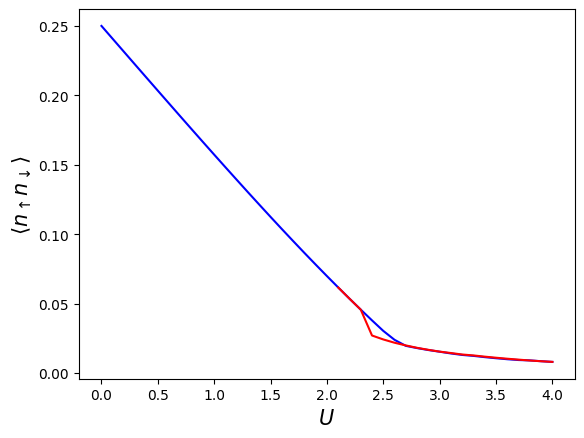

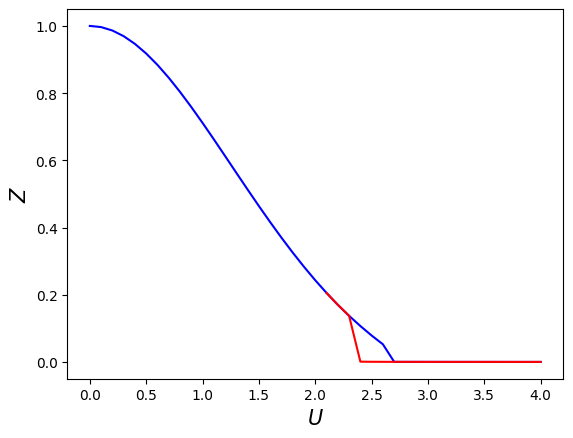

In [22]:
data_m2i = np.loadtxt('U_occ_docc_Z_diff_metal2mott.dat').T
data_i2m = np.loadtxt('../mott2metal/U_occ_docc_Z_diff_mott2metal.dat').T

plt.plot(data_m2i[0], data_m2i[3], 'b-')
plt.plot(data_i2m[0], data_i2m[3], 'r-')
plt.xlabel('$U$',size=15)
plt.ylabel(r'$\langle n_{\uparrow} n_{\downarrow} \rangle$', fontsize=15)
plt.show()

plt.plot(data_m2i[0], data_m2i[4], 'b-')
plt.plot(data_i2m[0], data_i2m[4], 'r-')
plt.xlabel('$U$',size=15)
plt.ylabel(r'$Z$', fontsize=15)
plt.show()

# Metal-Mott-insulator transition: density of states

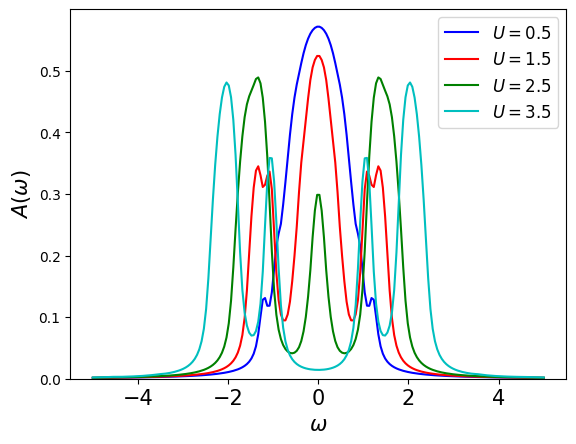

In [9]:
data_U0p5 = np.loadtxt('Glattw_U0.50.dat').T
data_U1p5 = np.loadtxt('Glattw_U1.50.dat').T
data_U2p5 = np.loadtxt('Glattw_U2.50.dat').T
data_U3p5 = np.loadtxt('Glattw_U3.50.dat').T

plt.plot(data_U0p5[0], -data_U0p5[2]/np.pi, 'b-', label='$U=0.5$')
plt.plot(data_U1p5[0], -data_U1p5[2]/np.pi, 'r-', label='$U=1.5$')
plt.plot(data_U2p5[0], -data_U2p5[2]/np.pi, 'g-', label='$U=2.5$')
plt.plot(data_U3p5[0], -data_U3p5[2]/np.pi, 'c-', label='$U=3.5$')

plt.xlabel('$\omega$',size=15)
plt.ylabel('$A(\omega$)',size=15)
plt.xticks(size=15)
plt.xticks(size=15)
plt.ylim(0,)
plt.legend(loc='best', fontsize=12)

plt.show()